## ST1504 Deep Learning CA2 

## Part A:  GAN

## DAAA/2A/02

## DONE BY: 

1. Lim Sheng Wei (p2309123)

2. Pei Joon Yi (p2300562)

# Background Information

In the world where data is very important, there are certain information that is sensitive or private. Using GAN allow us to generate new and unseen images which can be used for training of other models etc.


The Extended MNIST (EMNIST) dataset is an extension of the original MNIST dataset to include handwritten letters and digits. It is designed to serve as a benchmark dataset for handwritten recognition tasks. 
* This dataset contains letters from A to Z, thus having 26 classes. 
* Each image in the dataset is a 28x28 pixel grayscale image, similar to the MNIST dataset.
* There are total of 99040 rows with 785 columns (Excluding invalid labels, 88800 rows with 785 columns)

In [3]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


We check and print the number of GPUs available on your system for TensorFlow to use. 

In [2]:
from tensorflow.keras import backend as K

K.clear_session()

By clearing the session, it helps in freeing up the resources, including memory and computational resources used by the existing models and variables. 

## Exploratory Data Analysis

### Load the dataset

In [3]:
df=pd.read_csv('emnist-letters-train.csv')
df.head(20)

FileNotFoundError: [Errno 2] No such file or directory: 'emnist-letters-train.csv'

- The first column appears to represent the label for each row.

- The subsequent columns represent pixel values for the images.

### Filtering out invalid labels

Upon inspection, we noticed certain rows labeled as -1. These rows exhibit a uniform pixel value, resulting in a black screen. Consequently, they do not contribute meaningfully to our task.

In [4]:
# Filter out rows with label -1
df = df[df.iloc[:, 0] != -1]

# Proceed with extracting labels and pixel values
labels = df.iloc[:, 0].values
pixel_values = df.iloc[:, 1:].values
labels.shape


NameError: name 'df' is not defined

## Normalizing Pixel Values

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
images = scaler.fit_transform(pixel_values)

# Reshape images to 28x28
images = images.reshape(-1, 28, 28, 1)


# Transpose all images
transposed_images = np.array([np.transpose(image.reshape(28, 28)) for image in images])


In [7]:
# Check the range of pixel values
print(f"Min pixel value: {images.min()}")
print(f"Max pixel value: {images.max()}")

Min pixel value: -1.0
Max pixel value: 1.0



The MinMaxScaler is used to normalize the pixel values to be between -1 and 1, aligning with the range required by the tanh activation function, which will be employed in the generator later.

## Plotting images

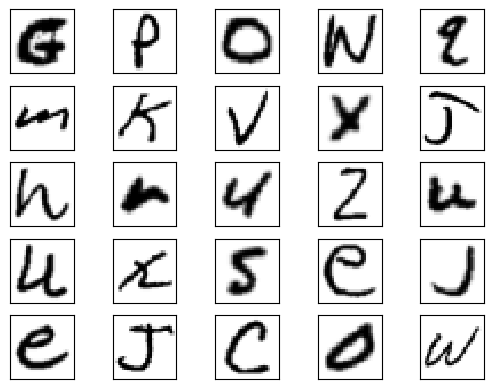

In [8]:
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(transposed_images.reshape(transposed_images.shape[0], 28, 28)[i], interpolation='nearest', cmap='gray_r')

## Checking Class distribution

When training a machine learning model, it is always important to check the distribution of the different
classes in the dataset. This will inform us which metrics is the best to use and if anything is needed to
balance the classes.

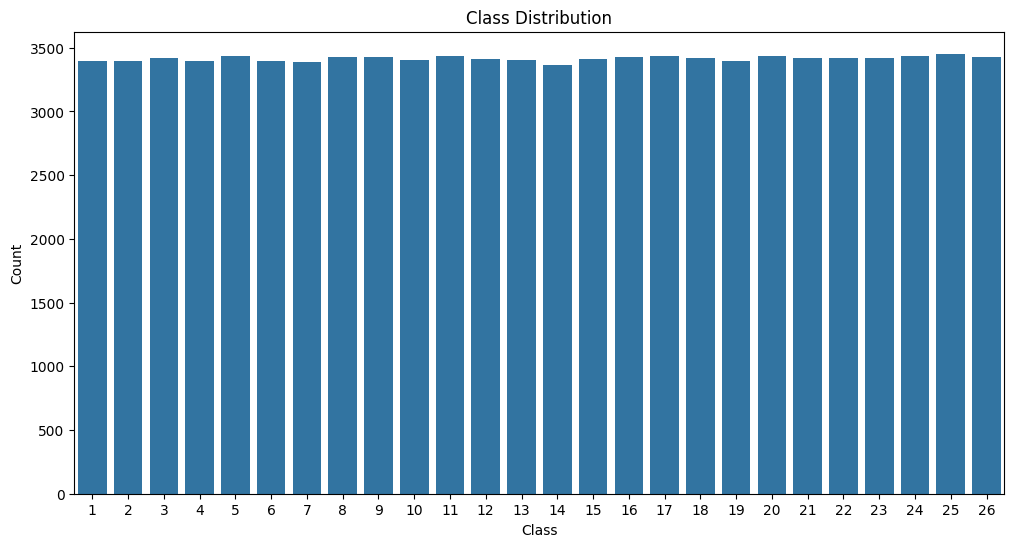

In [9]:
plt.figure(figsize=(12, 6))
sns.countplot(x=labels)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

As we can see from the count plot, the distribution of the images is even. This means that there will be no biases towards one particular class.

## Image Pixel Distribution

Analysing the pixel distribution can provide insight to how our images are structured.


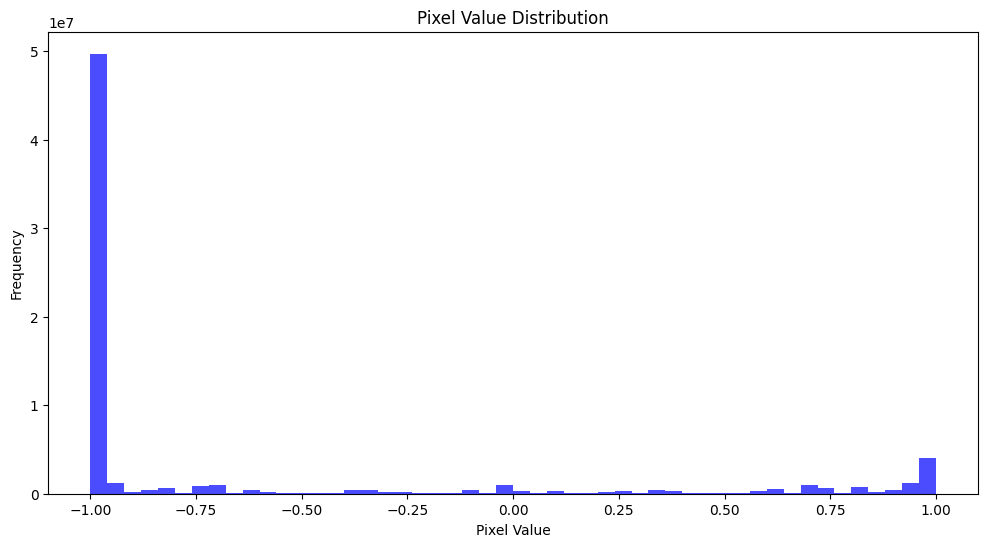

In [10]:
# Plot pixel value distribution
plt.figure(figsize=(12, 6))
plt.hist(transposed_images.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

- According to pixel value distrubution, it seems the majority of the image is black, likely due to the background being black, and there seems to a small peak at 1.0 likely due to the strokes of the character

### Imbalance in Pixel Distribution:

- The GAN might focus too much on generating the black background and not enough on the important features (strokes).

### Training Challenges:

- The discriminator may easily distinguish between real and generated images based on the predominance of black pixels, making it harder for the generator to improve

## Image Averaging

Image averaging involves stacking multiple photos on top of each other and averaging them together. The main purpose is to reduce noise in the images, thereby improving their overall quality.

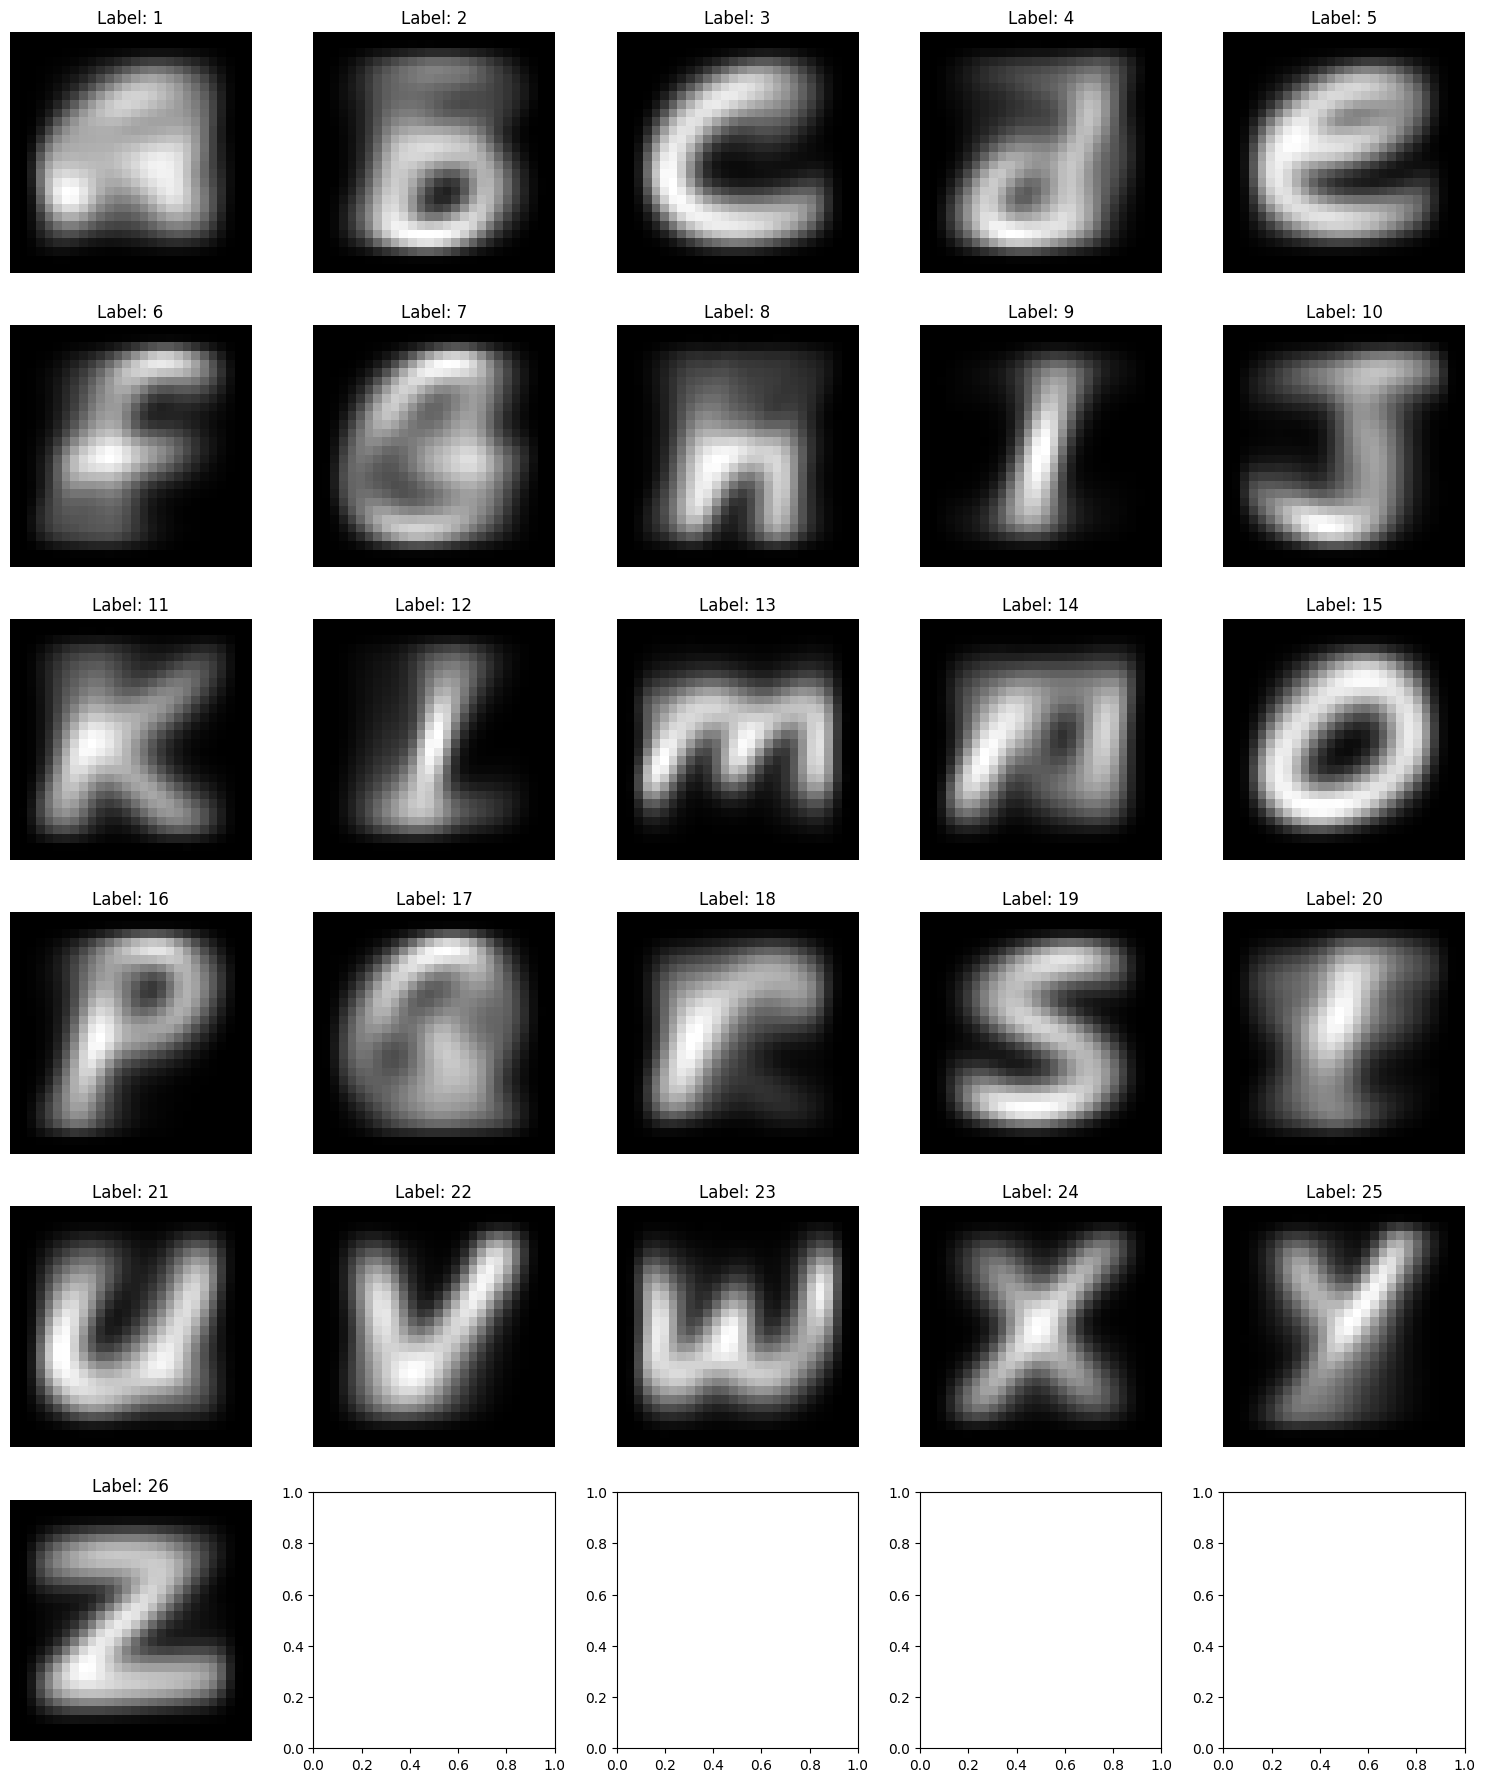

In [11]:
# Get the unique labels
unique_labels = np.unique(labels)

# Create a figure for the average images
fig, axes = plt.subplots(6, 5, figsize=(15, 18))

# Loop through each label and calculate the average image
for i, label in enumerate(unique_labels):
    # Select images for the current label
    selected_images = transposed_images[label == labels]

    # Compute the average image
    average_image = np.mean(selected_images, axis=0)

    # Plot the average image
    row, col = divmod(i, 5)
    axes[row, col].imshow(average_image, cmap='gray')
    axes[row, col].set_title(f'Label: {label}')
    axes[row, col].axis('off')  # Hide axes

# Adjust the layout
plt.tight_layout()
plt.show()

## What we learn from the Average Image

- The average images help identify the key features that the model needs to learn for each class, for instance, the consistent strokes or shapes that are visible in the average images are crucial features for classification

-  It seems that our dataset has some pretty clear pictures, meaning that most of the images are of good quality. 

- However, some letters like T, A and G seem to be relatively blurry, meaning that the strokes or features vary significantly across the images in that class, suggesting that our GAN model may encounter some difficulty when it comes to generating those images

- Data augmentation is one strategy to help improve consistency of the images.

# Feature Engineering

## Edge Detection

- Edge detection is a technique used to identify and locate sharp discontinuities in an image. 

- These discontinuities correspond to significant changes in intensity, which typically represent boundaries of objects within the image.

- The primary goal of edge detection is to capture important features of an image such as lines, curves, and shapes

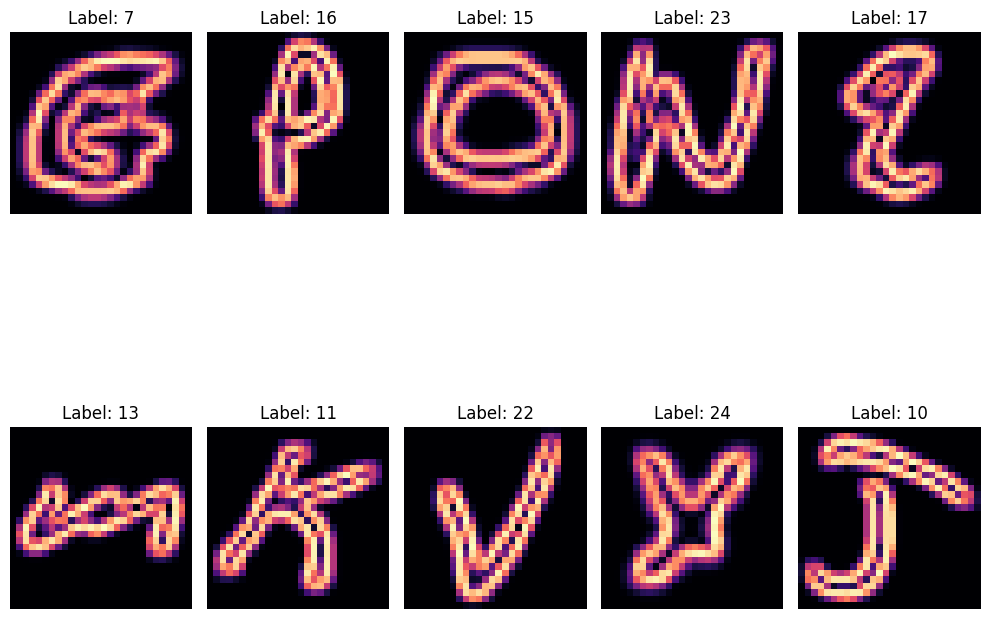

In [12]:
import matplotlib.pyplot as plt
from skimage import filters

# Apply edge detection (Sobel filter) to the images
edges = np.array([filters.sobel(image.squeeze()) for image in transposed_images])

# Display some edge-detected images
fig, axes = plt.subplots(2, 5, figsize=(10, 10))
for i in range(10):
    row, col = divmod(i, 5)
    axes[row, col].imshow(edges[i], cmap='magma')
    axes[row, col].set_title(f'Label: {labels[i]}')
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()


## Introducing LeNet5 as a model for FID and IS

![Alt text](..\assets\lenet5.jpg)

- LeNet-5 is one of the earliest convolutional neural networks was trained on handwritten digit recognition (specifically the MNIST dataset). It has a relatively simple architecture compared to modern deep networks and is well-suited for small, grayscale images like those found in the EMNIST dataset

-  This alignment means that LeNet-5 might extract more relevant features for FID calculation in this context compared to more complex models e.g InceptionV3 (which might be overkill for a simple dataset), leading to more meaningful evaluation of  GAN's performance.

- Here, I deployed a slightly modified version of the LeNet-5 model in order to fit the input size of the data as well as the number of classes in this dataset

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


# Normalize and reshape your dataset
# Ensure labels are integers and start from 0
labels = np.array(labels, dtype=int)
labels = labels - labels.min()

# Check if all labels are within the correct range
num_classes = len(np.unique(labels))
assert np.all(labels >= 0) and np.all(labels < num_classes), "Labels out of range"


# Define LeNet-5 model
input_shape = (28, 28, 1)
inputs = Input(shape=input_shape)
x = Conv2D(6, (5, 5),  strides=1, activation='tanh', padding='same')(inputs)
x = AveragePooling2D((2,2),strides=2,padding='valid')(x)
x = Conv2D(16, (5, 5), strides=1,activation='tanh')(x)
x = AveragePooling2D((2, 2), strides=2, padding='valid')(x)
x = Conv2D(120, (5, 5), strides=1, activation='tanh')(x)
x = Flatten()(x)
x = Dense(84, activation='tanh')(x)
outputs = Dense(num_classes, activation='softmax')(x)  # Ensure the number of classes matches your dataset

lenet_model = Model(inputs=inputs, outputs=outputs)


optimizer = Adam(learning_rate=0.001)
lenet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
lenet_model.fit(transposed_images, labels, epochs=10, validation_split=0.2)

# Save the trained LeNet-5 model for feature extraction
lenet_model.save('lenet_model.h5')


The training results of LeNet-5 model achieves high training and validation accuracies, indicating that the model has learned to extract meaningful features from the EMNIST dataset. This makes it a suitable choice for calculating the FID score for generated images, as it can effectively capture the nuances of the handwritten characters in the dataset.

## Testing Feature Extraction

To further evaluate LeNet5's feature extraction, I loaded the LeNet model. I would test it on 3 real images from the dataset, of which 2 of them would be from the same class and another one would be from a different class


In [14]:
from keras.models import load_model, Model

# Load the trained LeNet-5 model
lenet_model = load_model('lenet_model.h5')

In [15]:
# Access and print the weights of each layer
for layer in lenet_model.layers:
    weights = layer.get_weights()  # Returns a list of numpy arrays
    print(f'Layer: {layer.name}')
    for weight in weights:
        print(weight.shape)
        print(weight)


Layer: input_1
Layer: conv2d
(5, 5, 1, 6)
[[[[-0.00214154  0.39588642 -0.35177612  0.30421475  0.46211684
    -0.33638877]]

  [[-0.16712831 -0.07296947 -0.22687145 -0.01936102  0.3247125
    -0.39741674]]

  [[-0.34119046  0.02382909 -0.03041886  0.13323441  0.33875042
    -0.3911639 ]]

  [[-0.15771388 -0.27778363  0.14771217  0.01476565  0.22008483
    -0.541306  ]]

  [[-0.4443412  -0.46359733 -0.02738767  0.4579999   0.32047662
    -0.18967275]]]


 [[[-0.18104835  0.21898445 -0.27579945 -0.10442919  0.30278656
    -0.01954981]]

  [[-0.02500968 -0.13849044 -0.12491411 -0.44954354 -0.14729285
    -0.03275521]]

  [[-0.29574186 -0.3013022   0.1196435  -0.49471682 -0.39214388
     0.08426668]]

  [[-0.1616994  -0.27798134  0.00432028 -0.24038461 -0.28830156
    -0.04702258]]

  [[-0.35074255 -0.48313555 -0.26026547  0.27245784 -0.00724502
     0.07901724]]]


 [[[ 0.01326644  0.4814812   0.08913013 -0.4289141   0.19702484
     0.16645895]]

  [[ 0.07593204 -0.16409178  0.42024255 -0

1/1 [==============================] - 0s 22ms/step
Euclidean distance between two real image features within the same class: [[6.017802]]
Euclidean distance between two real image features not within the same class: [[11.879317]]


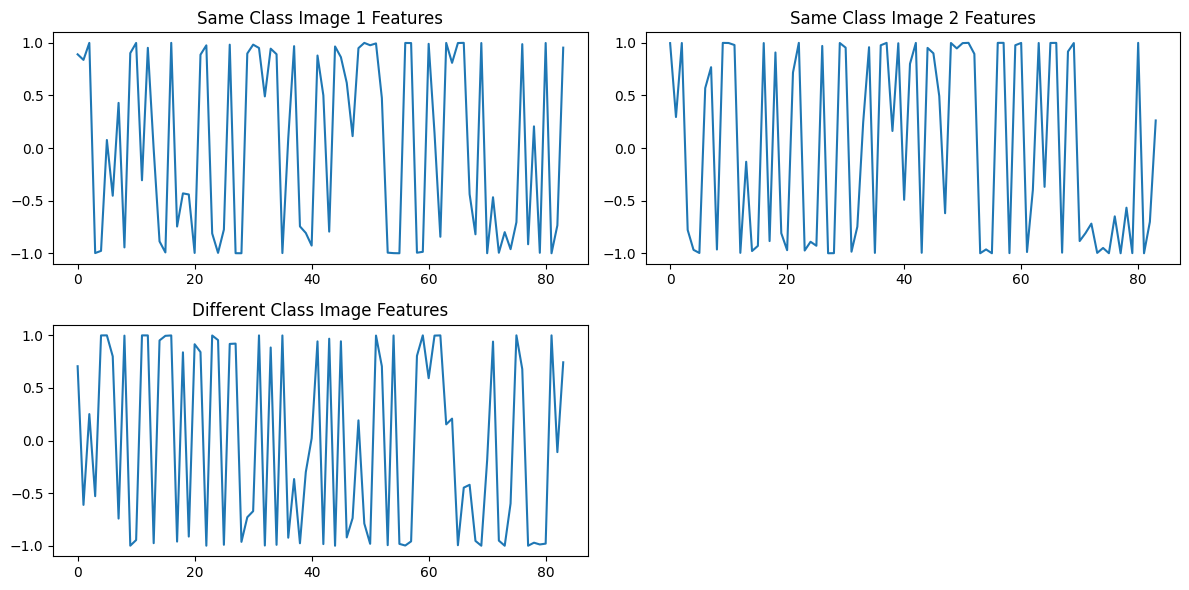

In [16]:
from keras.models import load_model, Model
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt



# Create a feature extractor model
feature_extractor = Model(inputs=lenet_model.input, outputs=lenet_model.get_layer('dense').output)

# Preprocess real images from the transposed images
def preprocess_real_image(image):
    img_array = image.astype('float32')  # Ensure the image is in float32 format
    img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension 
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Select two real images from transposed_images for comparison
real_image1 = preprocess_real_image(transposed_images[12])
real_image2 = preprocess_real_image(transposed_images[15])
real_image3 = preprocess_real_image(transposed_images[4])



# Extract features from both real images
real_features1 = feature_extractor.predict(real_image1)
real_features2 = feature_extractor.predict(real_image2)
real_features3 = feature_extractor.predict(real_image3)

# Calculate the Euclidean distance between the feature vectors
distance = euclidean_distances(real_features1, real_features2)
distance2 = euclidean_distances(real_features1, real_features3)
print('Euclidean distance between two real image features within the same class:', distance)
print('Euclidean distance between two real image features not within the same class:', distance2)

# Visualize the feature vectors
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.title('Same Class Image 1 Features')
plt.plot(real_features1.flatten())

plt.subplot(2, 2, 2)
plt.title('Same Class Image 2 Features')
plt.plot(real_features2.flatten())

plt.subplot(2, 2, 3)
plt.title('Different Class Image Features')
plt.plot(real_features3.flatten())

plt.tight_layout()
plt.show()

Euclidean Distance:

- The Euclidean distance between the feature vectors of the real and generated images is calculated.

- This distance quantifies how different the features of one image differ from another.

- A smaller distance would indicate that the  image is more similar to the real image, while a larger distance indicates more differences.

Key Observations:
1. Feature Vector Comparison:

- The feature vectors for images within the same class (top two plots) show more similarity compared to the feature vectors for images from different classes (bottom plot).

- This is evidenced by the patterns in the feature plots. Although there are variations, the overall trends and ranges of the feature values within the same class are more aligned compared to those from different classes.

2. Euclidean Distance:

- The Euclidean distance between the feature vectors of the same-class images is smaller compared to the distance between different-class images 

- This quantitative measure aligns with the visual inspection, confirming that LeNet-5 can effectively capture and distinguish between the features of images from different classes.


# Model Buildling

## Models used:

- DCGAN
- cGAN

## DCGAN with FID and IS

- Deep Convolutional Generative Adversarial Networks (DCGANs) are a class of GANs that leverage deep convolutional networks for both the generator and discriminator. These networks have shown remarkable success in generating high-quality images. 

- However, evaluating the performance of GANs, including DCGANs, can be challenging due to the subjective nature of image quality. One of the most widely used metrics for this purpose is the Frechet Inception Distance (FID) and Inception Distance (IS) 

### Understanding FID
The Frechet Inception Distance (FID) is a metric used to evaluate the quality of images generated by GANs. It measures the distance between the distributions of real and generated images. The FID score considers both the mean and covariance of the feature vectors extracted from a pre-trained  network.


The Frechet Inception Distance (FID) is calculated as:
$$
\text{FID} = || \mu_r - \mu_g ||^2 + \text{Tr}(\Sigma_r + \Sigma_g - 2(\Sigma_r \Sigma_g)^{1/2})
$$
where:
$$ 
-  \mu_r  \text { and } \mu_g \text {are the mean feature vectors of the real and generated images, respectively.}
$$

$$
- \Sigma_r \text{ and } \Sigma_g \text {are the covariance matrices of the real and generated images, respectively.}
$$ 
### Potential Drawbacks

- One key issue is that FID may be misleading when model faces mode collapse because the images may look similar to the real images, causing the mean and covariance of the generated images' features to be similar to those of real images, despite the lack of diversity.

- Hence, I introduced another metric IS which can help identify whether our model is facing mode collapse
 

### Understanding IS

The Inception Score (IS) is a metric used to evaluate the quality and diversity of images generated by Generative Adversarial Networks (GANs). It leverages a pre-trained classifier to assess the generated images. The Inception Score is based on two main criteria: image quality and diversity.

Characteristics of Inception Score

- High IS: A high Inception Score indicates that the generated images are both high quality and diverse (spanning multiple classes).

- Low IS: A low Inception Score suggests that the generated images may be of poor quality or lack diversity, indicating potential issues such as mode collapse.

### Model with LeNet5 and InceptionV3

As a baseline, I built a simple DCGAN model evaluated using both LeNet5 and InceptionV3, offering a comprenhensive side-by-side comparison of the FID and IS scores

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_584 (Conv2D)         (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 conv2d_585 (Conv2D)         (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 flatten_6 (Flatten)         (None, 6272)              0         
                                                                 
 dense_12 (Dense)            (None, 1)                 6273      
                                                                 
Total params: 80,769
Trainable params: 80,769
Non-tra

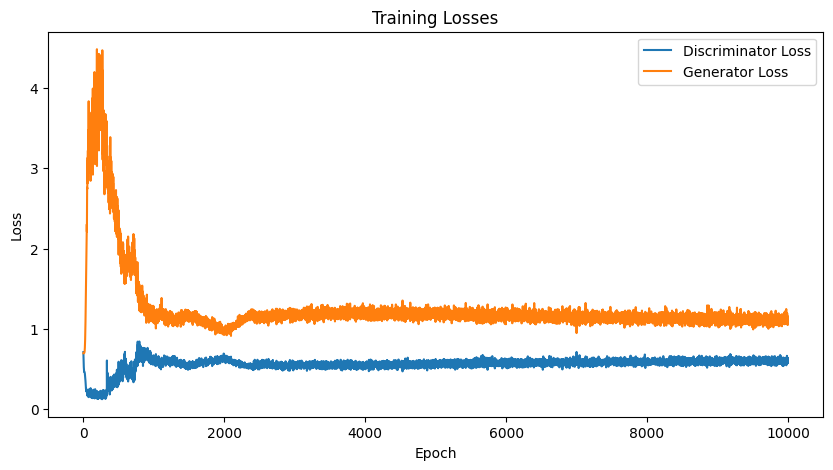

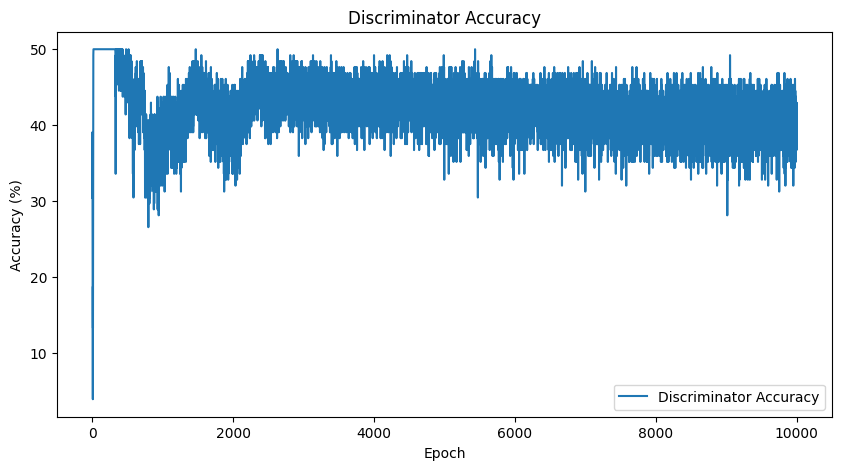

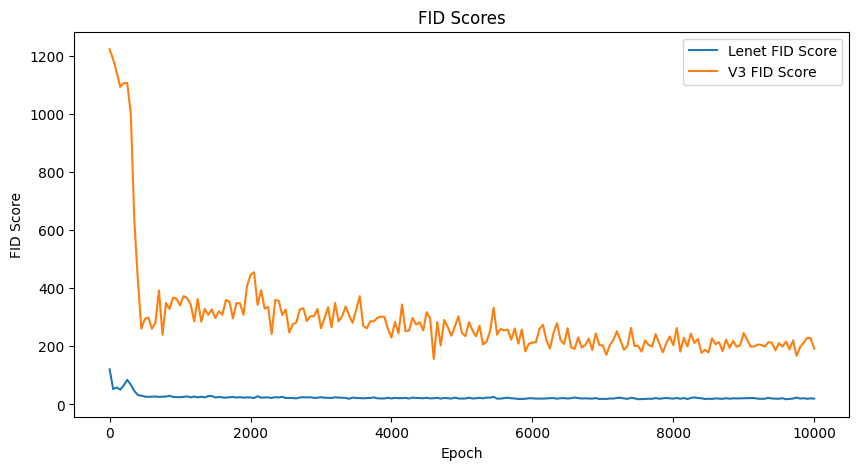

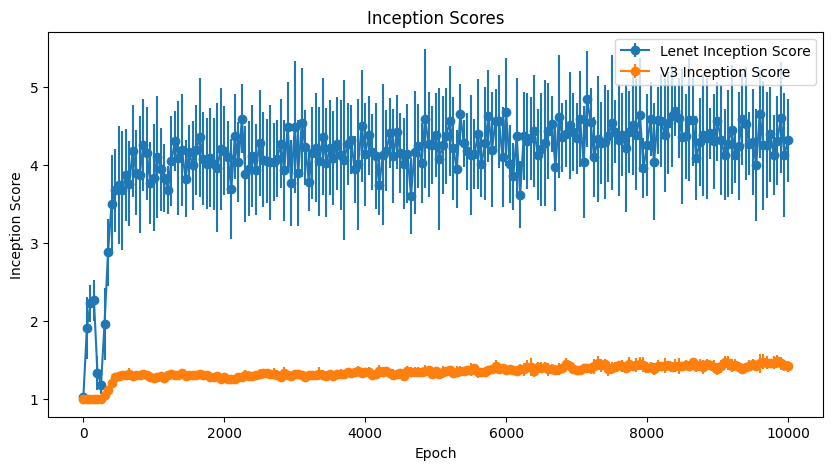

Lowest Lenet FID score: 17.861174860497727
Best Lenet Inception Score: 4.837529182434082
Lowest V3 FID score: 156.7530769709564
Best V3 Inception Score: 1.4847372770309448


In [23]:
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.transform import resize
from scipy.stats import entropy
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, LeakyReLU, Conv2D, Dropout, Flatten, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input


class DCGAN:
    def __init__(self, rows=28, cols=28, channels=1):
        # Input shape
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100  # Latent space dimension (input noise vector size)
        
        # Optimizer
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        
        # Build the generator
        self.generator = self.build_generator()
        
        # The generator takes noise as input and generates images
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        
        # For the combined model, we will only train the generator
        self.discriminator.trainable = False
        
        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)
        
        # The combined model (stacked generator and discriminator)
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

        # Initialize lists to store losses and accuracy
        self.d_losses = []
        self.g_losses = []
        self.d_accuracies = []

        self.v3_fid_scores = []
        self.v3_inception_scores = []

        self.lenet_fid_scores = []
        self.lenet_inception_scores = []

        self.lenet_lowest_fid = float('inf')
        self.lenet_best_inception_score = 0

        self.v3_lowest_fid = float('inf')
        self.v3_best_inception_score = 0

        # Load LeNet-5 model
        self.lenet_model = load_model('lenet_model.h5')

        # Feature extraction model
        self.feature_extractor = Model(inputs=self.lenet_model.input,
                                       outputs=self.lenet_model.get_layer(index=-2).output)

        # Load InceptionV3 model
        self.inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(75, 75, 3))

    def build_generator(self):
        model = Sequential(name='Generator')
        
        model.add(Dense(32 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 32)))
        
        # First Conv2DTranspose layer
        model.add(Conv2DTranspose(16, kernel_size=3, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        
        # Second Conv2DTranspose layer
        model.add(Conv2DTranspose(16, kernel_size=3, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        
        # Final Conv2D layer to get the desired output shape
        model.add(Conv2D(self.channels, kernel_size=3, padding='same', activation='tanh'))
        
        model.summary()
        
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        
        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential(name='Discriminator')
        
        model.add(Conv2D(256, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=self.img_shape)
        validity = model(img)
        
        return Model(img, validity)

    def preprocess_lenet(self, images):
        images = np.array([resize(image, (28, 28, 1)) for image in images])
        return images
    
    def calculate_lenet_fid(self, real_images, generated_images):
        real_images = self.preprocess_lenet(real_images)
        generated_images = self.preprocess_lenet(generated_images)

        real_activations = self.feature_extractor.predict(real_images)
        generated_activations = self.feature_extractor.predict(generated_images)

        # Check for NaNs in activations
        assert not np.any(np.isnan(real_activations)), "NaNs found in real activations"
        assert not np.any(np.isnan(generated_activations)), "NaNs found in generated activations"

        mu_real = np.mean(real_activations, axis=0)
        sigma_real = np.cov(real_activations, rowvar=False)
        mu_gen = np.mean(generated_activations, axis=0)
        sigma_gen = np.cov(generated_activations, rowvar=False)

        # Add small value to diagonal of covariance matrices
        epsilon = 1e-6
        sigma_real += np.eye(sigma_real.shape[0]) * epsilon
        sigma_gen += np.eye(sigma_gen.shape[0]) * epsilon

        ssdiff = np.sum((mu_real - mu_gen) ** 2.0)
        covmean = sqrtm(sigma_real @ sigma_gen)

        if np.iscomplexobj(covmean):
            covmean = covmean.real

        fid = ssdiff + np.trace(sigma_real + sigma_gen - 2.0 * covmean)
        return fid
    
    def calculate_lenet_inception_score(self, generated_images, num_splits=10):
        generated_images = self.preprocess_lenet(generated_images)

        # Predict class probabilities using the LeNet-5 model
        preds = self.lenet_model.predict(generated_images)

        # Calculate the Inception Score
        split_scores = []
        for k in range(num_splits):
            part = preds[k * len(preds) // num_splits: (k + 1) * len(preds) // num_splits]
            py = np.mean(part, axis=0)
            scores = []
            for i in range(part.shape[0]):
                pyx = part[i]
                scores.append(entropy(pyx, py))
            split_scores.append(np.exp(np.mean(scores)))
        return np.mean(split_scores), np.std(split_scores)

    def preprocess_v3(self, images):
        images = np.array([resize(image, (75, 75, 3)) for image in images])
        images = preprocess_input(images)
        return images
    
    def calculate_v3_fid(self, real_images, generated_images):
        real_images = self.preprocess_v3(real_images)
        generated_images = self.preprocess_v3(generated_images)

        real_activations = self.inception_model.predict(real_images)
        generated_activations = self.inception_model.predict(generated_images)

        # Check for NaNs in activations
        assert not np.any(np.isnan(real_activations)), "NaNs found in real activations"
        assert not np.any(np.isnan(generated_activations)), "NaNs found in generated activations"

        mu_real = np.mean(real_activations, axis=0)
        sigma_real = np.cov(real_activations, rowvar=False)
        mu_gen = np.mean(generated_activations, axis=0)
        sigma_gen = np.cov(generated_activations, rowvar=False)

        # Add small value to diagonal of covariance matrices
        epsilon = 1e-6
        sigma_real += np.eye(sigma_real.shape[0]) * epsilon
        sigma_gen += np.eye(sigma_gen.shape[0]) * epsilon

        ssdiff = np.sum((mu_real - mu_gen) ** 2.0)
        covmean = sqrtm(sigma_real @ sigma_gen)

        if np.iscomplexobj(covmean):
            covmean = covmean.real

        fid = ssdiff + np.trace(sigma_real + sigma_gen - 2.0 * covmean)
        return fid
    
    def calculate_v3_inception_score(self, generated_images, num_splits=10):
        generated_images = self.preprocess_v3(generated_images)

        # Predict class probabilities using the InceptionV3 model
        preds = self.inception_model.predict(generated_images)

        # Calculate the Inception Score
        split_scores = []
        for k in range(num_splits):
            part = preds[k * len(preds) // num_splits: (k + 1) * len(preds) // num_splits]
            py = np.mean(part, axis=0)
            scores = []
            for i in range(part.shape[0]):
                pyx = part[i]
                scores.append(entropy(pyx, py))
            split_scores.append(np.exp(np.mean(scores)))
        return np.mean(split_scores), np.std(split_scores)

    def train(self, X_train, epochs, batch_size=128, save_interval=50):
        # Adversarial ground truths
        valid = np.ones((batch_size, 1)) 
        fake = np.zeros((batch_size, 1)) 
        
        for epoch in range(epochs):
            # Train Discriminator
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # Train Generator
            g_loss = self.combined.train_on_batch(noise, valid)
            
            self.d_losses.append(d_loss[0])
            self.g_losses.append(g_loss)
            self.d_accuracies.append(100 * d_loss[1])

            # Plot the progress
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]:.2f}%] [G loss: {g_loss}]")
            
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
                
                # Calculate Lenet FID score
                lenet_fid_score = self.calculate_lenet_fid(imgs, gen_imgs)
                self.lenet_fid_scores.append(lenet_fid_score)
                print(f"Lenet FID score: {lenet_fid_score}")
                if lenet_fid_score < self.lenet_lowest_fid:
                    self.lenet_lowest_fid = lenet_fid_score
                    self.generator.save_weights('lenet_best_fid_generator_weights.h5')
                    print(f"New lowest Lenet FID score: {lenet_fid_score}. Model weights saved.")

                # Calculate Lenet Inception Score
                lenet_inception_score, lenet_inception_std = self.calculate_lenet_inception_score(gen_imgs)
                self.lenet_inception_scores.append((lenet_inception_score, lenet_inception_std))
                print(f"Lenet Inception Score: {lenet_inception_score} ± {lenet_inception_std}")
                if lenet_inception_score > self.lenet_best_inception_score:
                    self.lenet_best_inception_score = lenet_inception_score
                    self.generator.save_weights('lenet_best_inception_generator_weights.h5')
                    print(f"New best Lenet Inception Score: {lenet_inception_score}. Model weights saved.")

                # Calculate V3 FID score
                v3_fid_score = self.calculate_v3_fid(imgs, gen_imgs)
                self.v3_fid_scores.append(v3_fid_score)
                print(f"V3 FID score: {v3_fid_score}")
                if v3_fid_score < self.v3_lowest_fid:
                    self.v3_lowest_fid = v3_fid_score
                    self.generator.save_weights('v3_best_fid_generator_weights.h5')
                    print(f"New lowest V3 FID score: {v3_fid_score}. Model weights saved.")

                # Calculate V3 Inception Score
                v3_inception_score, v3_inception_std = self.calculate_v3_inception_score(gen_imgs)
                self.v3_inception_scores.append((v3_inception_score, v3_inception_std))
                print(f"V3 Inception Score: {v3_inception_score} ± {v3_inception_std}")
                if v3_inception_score > self.v3_best_inception_score:
                    self.v3_best_inception_score = v3_inception_score
                    self.generator.save_weights('v3_best_inception_generator_weights.h5')
                    print(f"New best V3 Inception Score: {v3_inception_score}. Model weights saved.")

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        fig, axs = plt.subplots(r, c, figsize=(10, 10))
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1

        os.makedirs('baseline', exist_ok=True)
        fig.savefig(f"baseline/dcgan_{epoch}.png")
        plt.close()


    def plot_losses(self):
        # Plot losses
        plt.figure(figsize=(10, 5))
        plt.plot(self.d_losses, label="Discriminator Loss")
        plt.plot(self.g_losses, label="Generator Loss")
        plt.title("Training Losses")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"baseline/dcgan_losses.png")
        plt.show()

        # Plot accuracy
        plt.figure(figsize=(10, 5))
        plt.plot(self.d_accuracies, label="Discriminator Accuracy")
        plt.title("Discriminator Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.legend()
        plt.savefig(f"baseline/dcgan_accuracy.png")
        plt.show()

        # Calculate the correct x-axis values for FID scores and Inception scores
        intervals = list(range(0, len(self.lenet_fid_scores) * 50, 50))

        # Plot combined FID scores
        plt.figure(figsize=(10, 5))
        plt.plot(intervals, self.lenet_fid_scores, label="Lenet FID Score")
        plt.plot(intervals, self.v3_fid_scores, label="V3 FID Score")
        plt.title("FID Scores")
        plt.xlabel("Epoch")
        plt.ylabel("FID Score")
        plt.xticks(range(0, max(intervals)+1, 2000))  # Set x-axis ticks every 2000 epochs
        plt.legend()
        plt.savefig(f"baseline/combined_fid_scores.png")
        plt.show()

        # Prepare Lenet and V3 Inception scores
        lenet_inception_scores = [score for score, std in self.lenet_inception_scores]
        lenet_inception_stds = [std for score, std in self.lenet_inception_scores]
        v3_inception_scores = [score for score, std in self.v3_inception_scores]
        v3_inception_stds = [std for score, std in self.v3_inception_scores]

        # Plot combined Inception Scores
        plt.figure(figsize=(10, 5))
        plt.errorbar(intervals, lenet_inception_scores, yerr=lenet_inception_stds, fmt='-o', label="Lenet Inception Score")
        plt.errorbar(intervals, v3_inception_scores, yerr=v3_inception_stds, fmt='-o', label="V3 Inception Score")
        plt.title("Inception Scores")
        plt.xlabel("Epoch")
        plt.ylabel("Inception Score")
        plt.xticks(range(0, max(intervals)+1, 2000))  # Set x-axis ticks every 2000 epochs
        plt.legend()
        plt.savefig(f"baseline/combined_inception_scores.png")
        plt.show()
        plt.close()

        # Print the lowest FID score and best Inception Score
        print(f"Lowest Lenet FID score: {self.lenet_lowest_fid}")
        print(f"Best Lenet Inception Score: {self.lenet_best_inception_score}")
        print(f"Lowest V3 FID score: {self.v3_lowest_fid}")
        print(f"Best V3 Inception Score: {self.v3_best_inception_score}")


# Example of using the DCGAN class
dcgan = DCGAN()
dcgan.train(transposed_images, epochs=10001, batch_size=64, save_interval=50)
dcgan.plot_losses()


1. Inception Scores
  - Plot Analysis:

      - The Inception Score starts low and quickly increases, stabilizing around a score of 4-5.
      
      - There is significant fluctuation in the scores across epochs, indicating variability in the quality and diversity of the generated images.
  
  - Interpretation:
      - An Inception Score of around 5 for EMNIST (26 classes) suggests that the model is generating diverse images but there is room for improvement in quality and diversity.
      
      - The fluctuation indicates that while some generated images are recognized as different classes, the overall quality is inconsistent.

2. Training Losses
  - Plot Analysis:

      - Both the discriminator and generator losses stabilize after an initial period of fluctuation.
      
      - The generator loss is consistently higher than the discriminator loss.
  
  - Interpretation:
      
      - Stable loss values indicate that the training process is stable.

      - The higher generator loss might suggest that the generator is still struggling to produce high-quality images that can fool the discriminator consistently.

3. FID Scores

  - Plot Analysis:
      
      - The FID score starts high and drops significantly, stabilizing around 20-25.

      - The FID score shows a decreasing trend and then stabilizes, which is a good sign.

  - Interpretation:

      - A lower FID score indicates that the generated images are becoming more similar to the real images.

      - A FID score stabilizing around 20-25 suggests that while the generated images are improving, there is still a noticeable difference compared to real images.

4. Generated Images
  
  - Quality and Diversity:

      - The images show variability and represent different classes.

      - However, many images appear blurry or indistinct, indicating the need for further improvement in image quality.

## Overall Evaluation

- Strengths:

    - The model shows a stable training process.

    - The Inception Score and FID scores improve over time, indicating that the model is learning and improving.

    - The generated images show variability, suggesting that the model is capturing the diversity of the dataset to some extent.



# Conditional Generative Adversarial Networks (CGAN)

## Overview
A Conditional Generative Adversarial Network (CGAN) is a type of GAN that incorporates auxiliary information into the data generation process. For handwritten letters, this auxiliary information would be the labels corresponding to each letter.

## Structure
The structure of a CGAN for generating handwritten letters involves two main components:

1. **Generator (G)**: The generator creates images of handwritten letters based on a random noise vector and a specific label (e.g., the letter 'A', 'B', etc.).
2. **Discriminator (D)**: The discriminator evaluates whether an input image is real (from the dataset) or fake (generated by the generator) while considering the label of the letter.

## How It Works
1. **Input**:
   - **Generator Input**: A noise vector \( z \) (usually sampled from a normal distribution) and a label \( c \) (one-hot encoded vector representing the letter).
   - **Discriminator Input**: An image \( x \) (real or generated) and the label \( c \).

2. **Training Process**:
   - **Discriminator Training**: The discriminator is trained to distinguish between real images of handwritten letters and fake ones generated by the generator, considering the label \( c \). It maximizes the probability of correctly identifying real images and minimizes the probability of incorrectly identifying fake images.
   - **Generator Training**: The generator is trained to create realistic handwritten letters that the discriminator cannot distinguish from real ones, conditioned on the label \( c \). It aims to minimize the probability that the discriminator correctly identifies the generated images as fake.

3. **Objective Functions**:
   - The discriminator's loss function is:
     $$
     \mathcal{L}_D = -\mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x|c)] - \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z|c)))]
     $$
   - The generator's loss function is:
     $$
     \mathcal{L}_G = -\mathbb{E}_{z \sim p_z(z)}[\log D(G(z|c))]
     $$



This approach allows us to generate specific handwritten letters based on the given labels, making the CGAN a powerful tool for tasks that require conditional image generation.




![Alt text](..\assets\cgan.jpg)

The CGAN should be built using the FunctionalAPI instead of SequentialAPI due to the fact that there are multiple inputs

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, LeakyReLU, Conv2D, Dropout, Flatten, Input, Embedding, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


# Split the data
X_train, X_test, y_train, y_test = train_test_split(transposed_images, labels, test_size=0.2, random_state=42)

# Define the discriminator
def define_discriminator(input_shape=(28, 28, 1), n_classes=26):
    in_labels = Input(shape=(1,))
    em = Embedding(n_classes, 10)(in_labels)
    d1 = Dense(input_shape[0] * input_shape[1])(em)
    d1 = Reshape((input_shape[0], input_shape[1], 1))(d1)
    image_input = Input(shape=input_shape)
    merge = Concatenate()([image_input, d1])

    fe = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(merge)
    fe = LeakyReLU(0.2)(fe)
    fe = Flatten()(fe)
    fe = Dropout(0.4)(fe)
    
    out_layer = Dense(1, activation='sigmoid')(fe)
    model = Model([image_input, in_labels], out_layer)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Define the generator
def define_generator(latent_dim, n_classes=26):
    label_input = Input(shape=(1,))
    em = Embedding(n_classes, 10)(label_input)
    nodes = 7 * 7
    em = Dense(nodes)(em)
    em = Reshape((7, 7, 1))(em)
    image_input = Input(shape=(latent_dim,))
    nodes = 64 * 7 * 7
    d1 = Dense(nodes)(image_input)
    d1 = LeakyReLU(0.2)(d1)
    d1 = Reshape((7, 7, 64))(d1)
    merge = Concatenate()([d1, em])
    gen = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(merge)
    gen = LeakyReLU(0.2)(gen)
    gen = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(gen)
    gen = LeakyReLU(0.2)(gen)
    out_layer = Conv2D(1, (7, 7), activation='tanh', padding='same')(gen)
    model = Model([image_input, label_input], out_layer)
    return model

def define_gan(g_model,d_model):

    # make the discriminator layer as non trainable
    d_model.trainable = False
    # get the noise and label input from the generator
    gen_noise, gen_label = g_model.input
    # get the output from the generator
    gen_output = g_model.output
    #connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output,gen_label])
    #define gan model as taking noise and label and outputting a #classification
    model = Model([gen_noise,gen_label],gan_output)
    opt = Adam(lr=0.0002,beta_1=0.5)
    model.compile(loss='binary_crossentropy',optimizer=opt)
    return model

# Load real samples
def load_real_samples():
    X_train = transposed_images
    y_train = labels
    X = np.expand_dims(X_train,axis=-1)
    X = X.astype('float32')
    return [X, y_train]

# Select real samples
def generate_real_samples(dataset, n_samples):
    images, labels = dataset
    ix = np.random.randint(0, images.shape[0], n_samples)
    X, Labels = images[ix], labels[ix]
    y = np.ones((n_samples, 1))
    return [X, Labels], y

# Generate points in latent space
def generate_latent_points(latent_dim, n_samples, n_classes=26):
    x_input = np.random.randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    labels = np.random.randint(0, n_classes, n_samples)
    return [z_input, labels]

# Use the generator to generate n fake samples, with class labels
def generate_fake_samples(latent_dim, n_samples, generator):
    z_input, labels = generate_latent_points(latent_dim, n_samples)
    images = generator.predict([z_input, labels])
    y = np.zeros((n_samples, 1))
    return [np.array(images), labels], y

# Save generated images by class
def save_generated_images_by_class(epoch, generator, latent_dim, n_classes=26):
    plt.figure(figsize=(10, 10))
    for class_label in range(n_classes):
        z_input = np.random.randn(1, latent_dim)
        labels = np.array([class_label + 1])  # Ensure labels are 1 to 26
        generated_image = generator.predict([z_input, labels])
        generated_image = (generated_image + 1) / 2.0
        plt.subplot(5, 6, class_label + 1)
        plt.axis('off')
        plt.imshow(generated_image[0, :, :, 0], cmap='gray_r')
        plt.title(chr(65 + class_label))
    filename = f'baseCGANgenerated_classes_e{epoch + 1}.png'
    plt.savefig(filename)
    plt.close()

# Train the GAN
d_loss_real_list, d_loss_fake_list, g_loss_list = [], [], []
d_acc_real_list, d_acc_fake_list = [], []

def train_gan(gen_model,disc_model,gan_model,latent_dim,dataset,n_epochs=30,n_batches=256):
    batches_per_epoch = int(dataset[0].shape[0]/n_batches)
    half_batch = int(n_batches/2)
    for i in range(n_epochs):
        print('Epoch', i + 1)        
        for j in range(batches_per_epoch):
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            [X_fake, labels_fake], y_fake = generate_fake_samples(latent_dim, half_batch, gen_model)
            d_loss_real, d_acc_real = disc_model.train_on_batch([X_real, labels_real], y_real)
            d_loss_fake, d_acc_fake = disc_model.train_on_batch([X_fake, labels_fake], y_fake)
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batches)
            y_gan = np.ones((n_batches, 1))
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            d_loss_real_list.append(d_loss_real)
            d_loss_fake_list.append(d_loss_fake)
            d_acc_real_list.append(d_acc_real)
            d_acc_fake_list.append(d_acc_fake)
            g_loss_list.append(g_loss)
        
        d_loss_real_avg = np.mean(d_loss_real_list)
        d_loss_fake_avg = np.mean(d_loss_fake_list)
        d_acc_real_avg = np.mean(d_acc_real_list)
        d_acc_fake_avg = np.mean(d_acc_fake_list)
        g_loss_avg = np.mean(g_loss_list)
        
        print(f'> Discriminator real loss: {d_loss_real_avg:.3f}, acc: {d_acc_real_avg:.3f}')
        print(f'> Discriminator fake loss: {d_loss_fake_avg:.3f}, acc: {d_acc_fake_avg:.3f}')
        print(f'> Generator loss: {g_loss_avg:.3f}')
        
        if (i + 1) % 10 == 0 or i == 0:
            save_generated_images_by_class(i, gen_model, latent_dim)


# Load real samples
dataset = load_real_samples()

# Size of the latent space
latent_dim = 100

# Create the discriminator
d_model = define_discriminator()

# Create the generator
g_model = define_generator(latent_dim)

# Create the GAN
gan_model = define_gan(g_model, d_model)

# Train the GAN
model = train_gan(g_model, d_model, gan_model, latent_dim, dataset)

Epoch 1
4/4 [==============================] - 0s 4ms/step
> Discriminator real loss: 0.337, acc: 0.875
> Discriminator fake loss: 0.585, acc: 0.721
> Generator loss: 1.031
1/1 [==============================] - 0s 22ms/step
Epoch 2
4/4 [==============================] - 0s 4ms/step
> Discriminator real loss: 0.491, acc: 0.745
> Discriminator fake loss: 0.617, acc: 0.666
> Generator loss: 0.944
Epoch 3
4/4 [==============================] - 0s 4ms/step
> Discriminator real loss: 0.570, acc: 0.642
> Discriminator fake loss: 0.651, acc: 0.596
> Generator loss: 0.888
Epoch 4
4/4 [==============================] - 0s 4ms/step
> Discriminator real loss: 0.602, acc: 0.604
> Discriminator fake loss: 0.663, acc: 0.560
> Generator loss: 0.865
Epoch 5
4/4 [==============================] - 0s 4ms/step
> Discriminator real loss: 0.618, acc: 0.595
> Discriminator fake loss: 0.672, acc: 0.524
> Generator loss: 0.852
Epoch 6
4/4 [==============================] - 0s 5ms/step
> Discriminator real los

## Plot Results of cGAN

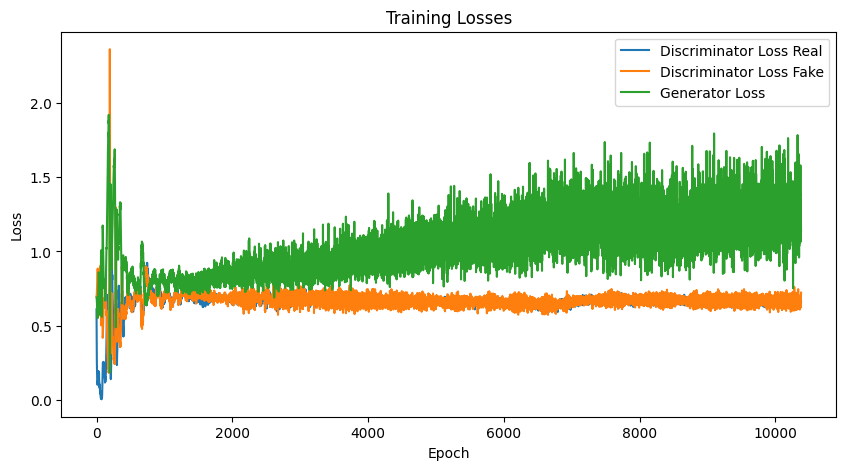

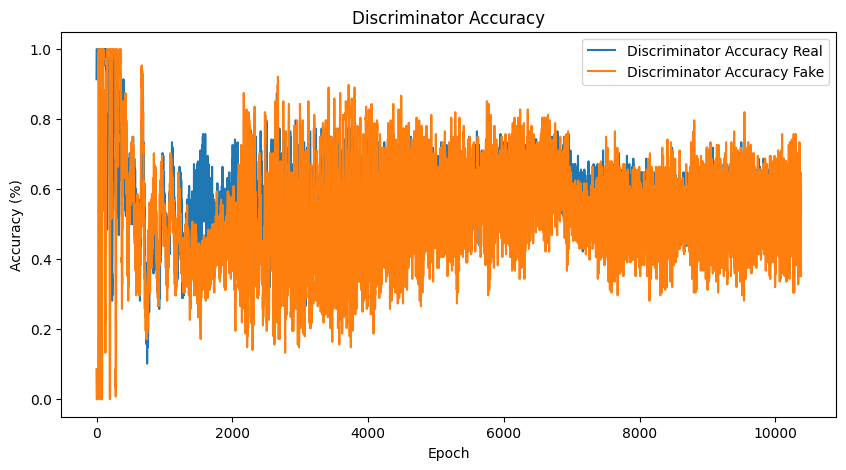

In [ ]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(d_loss_real_list, label="Discriminator Loss Real")
plt.plot(d_loss_fake_list, label="Discriminator Loss Fake")
plt.plot(g_loss_list, label="Generator Loss")
plt.title("Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("CGAN/cgan_losses.png")
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(d_acc_real_list, label="Discriminator Accuracy Real")
plt.plot(d_acc_fake_list, label="Discriminator Accuracy Fake")
plt.title("Discriminator Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.savefig("CGAN/cgan_accuracies.png")
plt.show()

1. Training Losses

- The generator loss is increasing as epochs go by, which is not a good sign. This means that our generator is struggling to create realisitic images to fool the discriminator. or the discriminator is too strong. 

2. Discriminator Accuracy

- The discriminator accuracy shows high variability, and has high accuracy, suggesting that it is very confident with its choices. 

Overall, we can tell that the discriminator is dominating the training process, and that we can improve the complexity of the generator and tune our hyperparameters to improve performance

## Generating Images

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def save_generated_images_by_class(generator, latent_dim, n_classes=26, n_images=10):
    # Define the splitting point
    midpoint = n_classes // 2

    # Generate and save images for the first half of the classes (A to M)
    plt.figure(figsize=(10, 10)) 
    image_index = 1

    for class_label in range(midpoint):
        for i in range(n_images):
            z_input = np.random.randn(1, latent_dim)
            labels = np.array([class_label + 1])  # Ensure labels are 1 to 26
            generated_image = generator.predict([z_input, labels])
            generated_image = (generated_image + 1) / 2.0  # Rescale to [0, 1]

            # Plot the generated image
            plt.subplot(midpoint, n_images, image_index)
            plt.axis('off')
            plt.imshow(generated_image[0, :, :, 0], cmap='gray_r')
            
            if i == 0:
                plt.title(chr(65 + class_label), fontsize=12)  # Label the first image of each row with the class letter
            
            image_index += 1

    plt.tight_layout()
    filename = f'baselinegenerated_classes_first_half.png'
    plt.savefig(filename, dpi=300)
    plt.close()

    # Generate and save images for the second half of the classes (N to Z)
    plt.figure(figsize=(10, 10))  
    image_index = 1

    for class_label in range(midpoint, n_classes):
        for i in range(n_images):
            z_input = np.random.randn(1, latent_dim)
            labels = np.array([class_label + 1])
            generated_image = generator.predict([z_input, labels])
            generated_image = (generated_image + 1) / 2.0  # Rescale to [0, 1]

            # Plot the generated image
            plt.subplot(midpoint, n_images, image_index)
            plt.axis('off')
            plt.imshow(generated_image[0, :, :, 0], cmap='gray_r')
            
            if i == 0:
                plt.title(chr(65 + class_label), fontsize=12)  # Label the first image of each row with the class letter
            
            image_index += 1

    plt.tight_layout()
    filename = f'baselinegenerated_classes_second_half.png'
    plt.savefig(filename, dpi=300)
    plt.close()

# Example usage (assuming g_model is your trained generator and latent_dim is defined)
save_generated_images_by_class(generator=g_model, latent_dim=100)


1/1 [==============================] - 0s 27ms/step


# Model Improvement 

### Improved DCGAN

As part of model improvment, 

1. I added more layers and neurons to both the discriminator and generator.

2. I added batch normalization to the generator to help stablise the learning process and added dorpout to the discriminator to help prevent it from overfiitting.

3. I also increased the kernel size to allow the model to capture more information

4. I did some label smoothing as well to help the discriminator to not be over confident in predicting labels.

In [28]:
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.feature import canny
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, LeakyReLU, Conv2D, Dropout, Flatten, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from scipy.linalg import sqrtm
from skimage.transform import resize
from scipy.stats import entropy
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input


class DCGAN:
    def __init__(self, rows=28, cols=28, channels=1):
        # Input shape
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100  # Latent space dimension (input noise vector size)
        
        # Optimizer
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        
        # Build the generator
        self.generator = self.build_generator()
        
        # The generator takes noise as input and generates images
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        
        # For the combined model, we will only train the generator
        self.discriminator.trainable = False
        
        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)
        
        # The combined model (stacked generator and discriminator)
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

        # Initialize lists to store losses and accuracy
        self.d_losses = []
        self.g_losses = []
        self.d_accuracies = []

        self.v3_fid_scores = []
        self.v3_inception_scores = []

        self.lenet_fid_scores = []
        self.lenet_inception_scores = []

        self.lenet_lowest_fid = float('inf')
        self.lenet_best_inception_score = 0

        self.v3_lowest_fid = float('inf')
        self.v3_best_inception_score = 0

        # Load LeNet-5 model
        self.lenet_model = load_model('lenet_model.h5')

        # Feature extraction model
        self.feature_extractor = Model(inputs=self.lenet_model.input,
                                       outputs=self.lenet_model.get_layer(index=-2).output)

        # Load InceptionV3 model
        self.inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(75, 75, 3))

    def build_generator(self):
        model = Sequential(name='Generator')
        
        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        
        # First Conv2DTranspose layer
        
        model.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=5, strides=1, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        # Second Conv2DTranspose layer
        model.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        # Final Conv2D layer to get the desired output shape
        model.add(Conv2D(self.channels, kernel_size=3, padding='same', activation='tanh'))
        
        model.summary()
        
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        
        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential(name='Discriminator')
        model.add(Conv2D(64, kernel_size=5, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=7, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=5, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=self.img_shape)
        validity = model(img)
        
        return Model(img, validity)

    def preprocess_lenet(self, images):
        images = np.array([resize(image, (28, 28, 1)) for image in images])
        return images
        
    def calculate_lenet_fid(self, real_images, generated_images):
        real_images = self.preprocess_lenet(real_images)
        generated_images = self.preprocess_lenet(generated_images)

        real_activations = self.feature_extractor.predict(real_images)
        generated_activations = self.feature_extractor.predict(generated_images)

        # Check for NaNs in activations
        assert not np.any(np.isnan(real_activations)), "NaNs found in real activations"
        assert not np.any(np.isnan(generated_activations)), "NaNs found in generated activations"

        mu_real = np.mean(real_activations, axis=0)
        sigma_real = np.cov(real_activations, rowvar=False)
        mu_gen = np.mean(generated_activations, axis=0)
        sigma_gen = np.cov(generated_activations, rowvar=False)

        # Add small value to diagonal of covariance matrices
        epsilon = 1e-6
        sigma_real += np.eye(sigma_real.shape[0]) * epsilon
        sigma_gen += np.eye(sigma_gen.shape[0]) * epsilon

        ssdiff = np.sum((mu_real - mu_gen) ** 2.0)
        covmean = sqrtm(sigma_real @ sigma_gen)

        if np.iscomplexobj(covmean):
            covmean = covmean.real

        fid = ssdiff + np.trace(sigma_real + sigma_gen - 2.0 * covmean)
        return fid

    def calculate_lenet_inception_score(self, generated_images, num_splits=10):
        generated_images = self.preprocess_lenet(generated_images)

        # Predict class probabilities using the LeNet-5 model
        preds = self.lenet_model.predict(generated_images)

        # Calculate the Inception Score
        split_scores = []
        for k in range(num_splits):
            part = preds[k * len(preds) // num_splits: (k + 1) * len(preds) // num_splits]
            py = np.mean(part, axis=0)
            scores = []
            for i in range(part.shape[0]):
                pyx = part[i]
                scores.append(entropy(pyx, py))
            split_scores.append(np.exp(np.mean(scores)))
        return np.mean(split_scores), np.std(split_scores)

    def preprocess_v3(self, images):
        images = np.array([resize(image, (75, 75, 3)) for image in images])
        images = preprocess_input(images)
        return images

    def calculate_v3_fid(self, real_images, generated_images):
        real_images = self.preprocess_v3(real_images)
        generated_images = self.preprocess_v3(generated_images)

        real_activations = self.inception_model.predict(real_images)
        generated_activations = self.inception_model.predict(generated_images)

        # Check for NaNs in activations
        assert not np.any(np.isnan(real_activations)), "NaNs found in real activations"
        assert not np.any(np.isnan(generated_activations)), "NaNs found in generated activations"

        mu_real = np.mean(real_activations, axis=0)
        sigma_real = np.cov(real_activations, rowvar=False)
        mu_gen = np.mean(generated_activations, axis=0)
        sigma_gen = np.cov(generated_activations, rowvar=False)

        # Add small value to diagonal of covariance matrices
        epsilon = 1e-6
        sigma_real += np.eye(sigma_real.shape[0]) * epsilon
        sigma_gen += np.eye(sigma_gen.shape[0]) * epsilon

        ssdiff = np.sum((mu_real - mu_gen) ** 2.0)
        covmean = sqrtm(sigma_real @ sigma_gen)

        if np.iscomplexobj(covmean):
            covmean = covmean.real

        fid = ssdiff + np.trace(sigma_real + sigma_gen - 2.0 * covmean)
        return fid

    def calculate_v3_inception_score(self, generated_images, num_splits=10):
        generated_images = self.preprocess_v3(generated_images)

        # Predict class probabilities using the InceptionV3 model
        preds = self.inception_model.predict(generated_images)

        # Calculate the Inception Score
        split_scores = []
        for k in range(num_splits):
            part = preds[k * len(preds) // num_splits: (k + 1) * len(preds) // num_splits]
            py = np.mean(part, axis=0)
            scores = []
            for i in range(part.shape[0]):
                pyx = part[i]
                scores.append(entropy(pyx, py))
            split_scores.append(np.exp(np.mean(scores)))
        return np.mean(split_scores), np.std(split_scores)


    
    def add_instance_noise(self, images, noise_level=0.1):
        noise = np.random.normal(0, noise_level, images.shape)
        return images + noise

    def train(self, X_train, epochs, batch_size=64, save_interval=50):
        
        # Adversarial ground truths
        valid = np.random.uniform(0.7, 1.2, (batch_size, 1))  # Smoothed real labels
        fake = np.zeros((batch_size, 1))  # Smoothed fake labels
        
        for epoch in range(epochs):
            # Train Discriminator
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # Train Generator
            g_loss = self.combined.train_on_batch(noise, valid)
            
            self.d_losses.append(d_loss[0])
            self.g_losses.append(g_loss)
            self.d_accuracies.append(100 * d_loss[1])

            # Plot the progress
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]:.2f}%] [G loss: {g_loss}]")
            
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
                
                # Calculate Lenet FID score
                lenet_fid_score = self.calculate_lenet_fid(imgs, gen_imgs)
                self.lenet_fid_scores.append(lenet_fid_score)
                print(f"Lenet FID score: {lenet_fid_score}")
                if lenet_fid_score < self.lenet_lowest_fid:
                    self.lenet_lowest_fid = lenet_fid_score
                    self.generator.save_weights('improved_lenet_best_fid_generator_weights.h5')
                    print(f"New lowest Lenet FID score: {lenet_fid_score}. Model weights saved.")

                # Calculate Lenet Inception Score
                lenet_inception_score, lenet_inception_std = self.calculate_lenet_inception_score(gen_imgs)
                self.lenet_inception_scores.append((lenet_inception_score, lenet_inception_std))
                print(f"Lenet Inception Score: {lenet_inception_score} ± {lenet_inception_std}")
                if lenet_inception_score > self.lenet_best_inception_score:
                    self.lenet_best_inception_score = lenet_inception_score
                    self.generator.save_weights('improved_lenet_best_inception_generator_weights.h5')
                    print(f"New best Lenet Inception Score: {lenet_inception_score}. Model weights saved.")

                # Calculate V3 FID score
                v3_fid_score = self.calculate_v3_fid(imgs, gen_imgs)
                self.v3_fid_scores.append(v3_fid_score)
                print(f"V3 FID score: {v3_fid_score}")
                if v3_fid_score < self.v3_lowest_fid:
                    self.v3_lowest_fid = v3_fid_score
                    self.generator.save_weights('improved_v3_best_fid_generator_weights.h5')
                    print(f"New lowest V3 FID score: {v3_fid_score}. Model weights saved.")

                # Calculate V3 Inception Score
                v3_inception_score, v3_inception_std = self.calculate_v3_inception_score(gen_imgs)
                self.v3_inception_scores.append((v3_inception_score, v3_inception_std))
                print(f"V3 Inception Score: {v3_inception_score} ± {v3_inception_std}")
                if v3_inception_score > self.v3_best_inception_score:
                    self.v3_best_inception_score = v3_inception_score
                    self.generator.save_weights('improved_v3_best_inception_generator_weights.h5')
                    print(f"New best V3 Inception Score: {v3_inception_score}. Model weights saved.")

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        fig, axs = plt.subplots(r, c, figsize=(10, 10))
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1

        os.makedirs('improvedmodel', exist_ok=True)
        fig.savefig(f"improvedmodel/dcgan_mnist_{epoch}.png")
        plt.close()




    def plot_losses(self):
        # Plot losses
        plt.figure(figsize=(10, 5))
        plt.plot(self.d_losses, label="Discriminator Loss")
        plt.plot(self.g_losses, label="Generator Loss")
        plt.title("Training Losses")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"improvedmodel/dcgan_losses.png")
        plt.show()

        # Plot accuracy
        plt.figure(figsize=(10, 5))
        plt.plot(self.d_accuracies, label="Discriminator Accuracy")
        plt.title("Discriminator Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.legend()
        plt.savefig(f"improvedmodel/dcgan_accuracy.png")
        plt.show()

         # Calculate the correct x-axis values for FID scores and Inception scores
        intervals = list(range(0, len(self.lenet_fid_scores) * 50, 50))

        # Plot combined FID scores
        plt.figure(figsize=(10, 5))
        plt.plot(intervals, self.lenet_fid_scores, label="Lenet FID Score")
        plt.plot(intervals, self.v3_fid_scores, label="V3 FID Score")
        plt.title("FID Scores")
        plt.xlabel("Epoch")
        plt.ylabel("FID Score")
        plt.xticks(range(0, max(intervals)+1, 2000))  # Set x-axis ticks every 2000 epochs
        plt.legend()
        plt.savefig(f"improvedmodel/combined_fid_scores.png")
        plt.show()

        # Prepare Lenet and V3 Inception scores
        lenet_inception_scores = [score for score, std in self.lenet_inception_scores]
        lenet_inception_stds = [std for score, std in self.lenet_inception_scores]
        v3_inception_scores = [score for score, std in self.v3_inception_scores]
        v3_inception_stds = [std for score, std in self.v3_inception_scores]

        # Plot combined Inception Scores
        plt.figure(figsize=(10, 5))
        plt.errorbar(intervals, lenet_inception_scores, yerr=lenet_inception_stds, fmt='-o', label="Lenet Inception Score")
        plt.errorbar(intervals, v3_inception_scores, yerr=v3_inception_stds, fmt='-o', label="V3 Inception Score")
        plt.title("Inception Scores")
        plt.xlabel("Epoch")
        plt.ylabel("Inception Score")
        plt.xticks(range(0, max(intervals)+1, 2000))  # Set x-axis ticks every 2000 epochs
        plt.legend()
        plt.savefig(f"improvedmodel/combined_inception_scores.png")
        plt.show()
        plt.close()

        # Print the lowest FID score and best Inception Score
        print(f"Lowest Lenet FID score: {self.lenet_lowest_fid}")
        print(f"Best Lenet Inception Score: {self.lenet_best_inception_score}")
        print(f"Lowest V3 FID score: {self.v3_lowest_fid}")
        print(f"Best V3 Inception Score: {self.v3_best_inception_score}")


# Example of using the DCGAN class
dcgan = DCGAN()
# Make sure to load your training data into transposed_images
# Example: transposed_images = load_data_function()
dcgan.train(transposed_images, epochs=15001, batch_size=64, save_interval=50)
dcgan.plot_losses()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_979 (Conv2D)         (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_51 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_18 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_980 (Conv2D)         (None, 7, 7, 256)         803072    
                                                                 
 leaky_re_lu_52 (LeakyReLU)  (None, 7, 7, 256)         0         
                                                                 
 dropout_19 (Dropout)        (None, 7, 7, 256)         0         
                                                                 
 conv2d_981 (Conv2D)         (None, 4, 4, 256)       

MemoryError: Unable to allocate 392. KiB for an array with shape (64, 28, 28) and data type float64

## Load the model

In [ ]:
# Load the saved weights
dcgan=DCGAN()
dcgan.generator.load_weights('best_generator_weights.h5')
dcgan.discriminator.load_weights('best_discriminator_weights.h5')

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_11 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_12 (Dropout)        (None, 7, 7, 128)         0         
                                                                 
 conv2d_16 (Conv2D)          (None, 4, 4, 512)       

## Generate Images

In [ ]:
import matplotlib.pyplot as plt

# Generate 200 images
noise = np.random.normal(0, 1, (260, dcgan.latent_dim))
generated_images = dcgan.generator.predict(noise)

def save_generated_images(generated_images, filename):
    r, c = 10, 20  # Grid size: 10 rows, 20 columns
    fig, axs = plt.subplots(r, c, figsize=(26, 10))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(generated_images[cnt, :, :, 0], cmap='gray_r')
            axs[i, j].axis('off')
            cnt += 1
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(filename)
    plt.close()

# Save the 200 generated images in one picture
save_generated_images(generated_images, 'bestgenerated_letters.png')


9/9 [==============================] - 1s 62ms/step


## Improved cGAN

As part of model improvement,

1. I added more layers and neurons to both my discriminator and generator to make it more complicated.

2. I added batch normalization to the generator to help stablise the learning process, and added dropout to the discriminator to mitigate overfitting

3. Increased the kernel size to allow the model to gather more information from the images. 

In [8]:
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.feature import canny
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, LeakyReLU, Conv2D, Dropout, Flatten, Input, BatchNormalization, Embedding, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from sklearn.model_selection import train_test_split
import tensorflow as tf
from scipy.linalg import sqrtm
from skimage.transform import resize



# define standalone discriminator
def define_discriminator(input_shape=(28,28,1),n_classes=26):
  # label input
  in_labels = Input(shape=(1,))
  # Embedding for categorical input
  em = Embedding(n_classes,50)(in_labels)
  # scale up the image dimension with linear activations
  d1 = Dense(input_shape[0] * input_shape[1])(em)
  # reshape to additional channel
  d1 = Reshape((input_shape[0],input_shape[1],1))(d1)
  # image input
  image_input = Input(shape=input_shape)
  #  concate label as channel
  merge = Concatenate()([image_input,d1])
  # downsample
  fe = Conv2D(128,(5,5),strides=(2,2),padding='same')(merge)
  fe = LeakyReLU(0.2)(fe)
  fe = Dropout(0.2)(fe)
  fe = Conv2D(128,(5,5),strides=(2,2),padding='same')(fe)
  fe = LeakyReLU(0.2)(fe)
  fe = Dropout(0.2)(fe)
  # downsample
  fe = Conv2D(256,(5,5),strides=(2,2),padding='same')(fe)
  fe = LeakyReLU(0.2)(fe)
  fe = Dropout(0.2)(fe)
  #flatten feature maps
  fe = Flatten()(fe)
  fe = Dropout(0.4)(fe)
  #ouput
  out_layer = Dense(1,activation='sigmoid')(fe)
  #define model
  model = Model([image_input,in_labels],out_layer)
  #compile model
  opt = Adam(lr=0.0002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt,metrics=  ['accuracy'])
  return model

def define_generator(latent_dim, n_classes=26):
    # Label input
    label_input = Input(shape=(1,))
    em = Embedding(n_classes, 50)(label_input)
    nodes = 7 * 7
    em = Dense(nodes)(em)
    em = Reshape((7, 7, 1))(em)
    
    # Latent input
    image_input = Input(shape=(latent_dim,))
    nodes = 128 * 7 * 7
    d1 = Dense(nodes)(image_input)
    d1 = LeakyReLU(0.2)(d1)
    d1 = BatchNormalization()(d1)
    d1 = Reshape((7, 7, 128))(d1)
    
    # Concatenate label as channel
    merge = Concatenate()([d1, em])
    
    # Upsample
    gen = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same')(merge)
    gen = LeakyReLU(0.2)(gen)
    gen = Conv2D(128, (5, 5), strides=(1, 1), padding='same')(gen)
    gen = LeakyReLU(0.2)(gen)

    gen = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same')(gen)
    gen = LeakyReLU(0.2)(gen)
    gen = BatchNormalization()(gen)

    
    # Output
    out_layer = Conv2D(1, (7, 7), activation='tanh', padding='same')(gen)
    model = Model([image_input, label_input], out_layer)
    return model

# defining the combined generator and discriminator model for updating the generator
def define_gan(g_model,d_model):
    d_model.trainable = False
    gen_noise, gen_label = g_model.input
    gen_output = g_model.output
    gan_output = d_model([gen_output,gen_label])
    model = Model([gen_noise,gen_label],gan_output)
    opt = Adam(lr=0.0002,beta_1=0.5)
    model.compile(loss='binary_crossentropy',optimizer=opt)
    return model

# load real samples
def load_real_samples():
    X_train = transposed_images
    y_train = labels
    X = np.expand_dims(X_train,axis=-1)
    X = X.astype('float32')
    return [X, y_train]

# select real samples
def generate_real_samples(dataset,n_samples):
    images,labels = dataset
    ix = np.random.randint(0,images.shape[0],n_samples)
    X, Labels = images[ix], labels[ix]
    y = np.ones((n_samples,1))
    return [X,Labels], y

# Generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=26):
    x_input = np.random.randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    labels = np.random.randint(1, n_classes + 1, n_samples)  # Ensure labels are 1 to 26
    return [z_input, labels]

# Use generator to generate n fake samples, with class labels
def generate_fake_samples(latent_dim, n_samples, generator):
    z_input, labels = generate_latent_points(latent_dim, n_samples)
    images = generator.predict([z_input, labels])
    y = np.zeros((n_samples, 1))
    return [np.array(images), labels], y

# Save generated images by class
def save_generated_images_by_class(epoch, generator, latent_dim, n_classes=26):
    plt.figure(figsize=(10, 10))
    for class_label in range(n_classes):
        z_input = np.random.randn(1, latent_dim)
        labels = np.array([class_label + 1])  # Ensure labels are 1 to 26
        generated_image = generator.predict([z_input, labels])
        generated_image = (generated_image + 1) / 2.0
        plt.subplot(5, 6, class_label + 1)
        plt.axis('off')
        plt.imshow(generated_image[0, :, :, 0], cmap='gray_r')
        plt.title(chr(65 + class_label))
    filename = f'generated_classes_e{epoch + 1}.png'
    plt.savefig(filename)
    plt.close()

d_loss_real_list, d_loss_fake_list, g_loss_list = [], [], []
d_acc_real_list, d_acc_fake_list = [], []

def train_gan(gen_model,disc_model,gan_model,latent_dim,dataset,n_epochs=50,n_batches=256):
    batches_per_epoch = int(dataset[0].shape[0]/n_batches)
    half_batch = int(n_batches/2)
    for i in range(n_epochs):
        print('Epoch', i + 1)
        
        
        
        for j in range(batches_per_epoch):
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            [X_fake, labels_fake], y_fake = generate_fake_samples(latent_dim, half_batch, gen_model)
            d_loss_real, d_acc_real = disc_model.train_on_batch([X_real, labels_real], y_real)
            d_loss_fake, d_acc_fake = disc_model.train_on_batch([X_fake, labels_fake], y_fake)
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batches)
            y_gan = np.ones((n_batches, 1))
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            d_loss_real_list.append(d_loss_real)
            d_loss_fake_list.append(d_loss_fake)
            d_acc_real_list.append(d_acc_real)
            d_acc_fake_list.append(d_acc_fake)
            g_loss_list.append(g_loss)
        
        d_loss_real_avg = np.mean(d_loss_real_list)
        d_loss_fake_avg = np.mean(d_loss_fake_list)
        d_acc_real_avg = np.mean(d_acc_real_list)
        d_acc_fake_avg = np.mean(d_acc_fake_list)
        g_loss_avg = np.mean(g_loss_list)
        
        print(f'> Discriminator real loss: {d_loss_real_avg:.3f}, acc: {d_acc_real_avg:.3f}')
        print(f'> Discriminator fake loss: {d_loss_fake_avg:.3f}, acc: {d_acc_fake_avg:.3f}')
        print(f'> Generator loss: {g_loss_avg:.3f}')
        
        if (i + 1) % 10 == 0 or i == 0:
            gen_model.save(f'c_gan_{i+1}.h5')
            save_generated_images_by_class(i, gen_model, latent_dim)



# Load real samples
dataset = load_real_samples()

# Size of the latent space
latent_dim = 100

# Create the discriminator
d_model = define_discriminator()
d_model.summary()

# Create the generator
g_model = define_generator(latent_dim)
g_model.summary()

# Create the GAN
gan_model = define_gan(g_model, d_model)

# Train the GAN
train_gan(g_model, d_model, gan_model, latent_dim, dataset)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        1300        ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1, 784)       39984       ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                              

c:\Users\fmlim\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 6272)         633472      ['input_4[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 leaky_re_lu_3 (LeakyReLU)      (None, 6272)         0           ['dense_3[0][0]']                
                                                                                            

KeyboardInterrupt: 

## Plotting the results

In [ ]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(d_loss_real_list, label="Discriminator Loss Real")
plt.plot(d_loss_fake_list, label="Discriminator Loss Fake")
plt.plot(g_loss_list, label="Generator Loss")
plt.title("Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("CGAN/cgan_losses.png")
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(d_acc_real_list, label="Discriminator Accuracy Real")
plt.plot(d_acc_fake_list, label="Discriminator Accuracy Fake")
plt.title("Discriminator Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.savefig("CGAN/cgan_accuracies.png")
plt.show()

- The addition of batch normalization in the generator and dropout in the discriminator appears to have helped in stabilizing the training process, as reflected in the relatively smooth curves post-initial spikes and no overfitting

## Generating pictures

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Specify the path to the weights file
weights_path = 'c_gan_50.h5'  

# Load the weights into the model
g_model.load_weights(weights_path)

def save_generated_images_by_class(generator, latent_dim, n_classes=26, n_images=10):
    # Define the splitting point
    midpoint = n_classes // 2

    # Generate and save images for the first half of the classes (A to M)
    plt.figure(figsize=(10, 10))
    image_index = 1

    for class_label in range(midpoint):
        for i in range(n_images):
            z_input = np.random.randn(1, latent_dim)
            labels = np.array([class_label + 1])  # Ensure labels are 1 to 26
            generated_image = generator.predict([z_input, labels])
            generated_image = (generated_image + 1) / 2.0  # Rescale to [0, 1]

            # Plot the generated image
            plt.subplot(midpoint, n_images, image_index)
            plt.axis('off')
            plt.imshow(generated_image[0, :, :, 0], cmap='gray_r')
            
            if i == 0:
                plt.title(chr(65 + class_label), fontsize=12)  # Label the first image of each row with the class letter
            
            image_index += 1

    plt.tight_layout()
    filename = f'generated_classes_first_half.png'
    plt.savefig(filename, dpi=300)
    plt.close()

    # Generate and save images for the second half of the classes (N to Z)
    plt.figure(figsize=(10, 10)) 
    image_index = 1

    for class_label in range(midpoint, n_classes):
        for i in range(n_images):
            z_input = np.random.randn(1, latent_dim)
            labels = np.array([class_label + 1])
            generated_image = generator.predict([z_input, labels])
            generated_image = (generated_image + 1) / 2.0  # Rescale to [0, 1]

            # Plot the generated image
            plt.subplot(midpoint, n_images, image_index)
            plt.axis('off')
            plt.imshow(generated_image[0, :, :, 0], cmap='gray_r')
            
            if i == 0:
                plt.title(chr(65 + class_label), fontsize=12)  # Label the first image of each row with the class letter
            
            image_index += 1

    plt.tight_layout()
    filename = f'generated_classes_second_half.png'
    plt.savefig(filename, dpi=300)
    plt.close()


save_generated_images_by_class(generator=g_model, latent_dim=100)


1/1 [==============================] - 0s 21ms/step


## Interpreting results


![Alt text](generated_classes_epoch_1.png)

From the picture above, the CGAN has managed to generate distinct representations for each class of letters, both uppercase and lowercase. This shows that the model has learned aspects of the distribution for each class.

## Data Augmentation

- Data augmentation artificially expands the training dataset by applying random transformations, such as rotations and shifts, to the existing images, thereby increasing data diversity and helping the model generalize better. 

- This technique prevents overfitting and improves the robustness and performance of GAN.

### Techniques applied

- These data augmentation settings introduce small rotations, shifts, shearing, and zooming to simulate natural variations in handwritten characters, enhancing the model's ability to generalize to different handwriting styles.

- Some image contrasting is also applied to ensure that the images remain strictly black and white, eliminating any intermediate grayscale pixels in the pixel distribution This helps the model focus on the key features of the handwritten characters without being distracted by unnecessary noise.

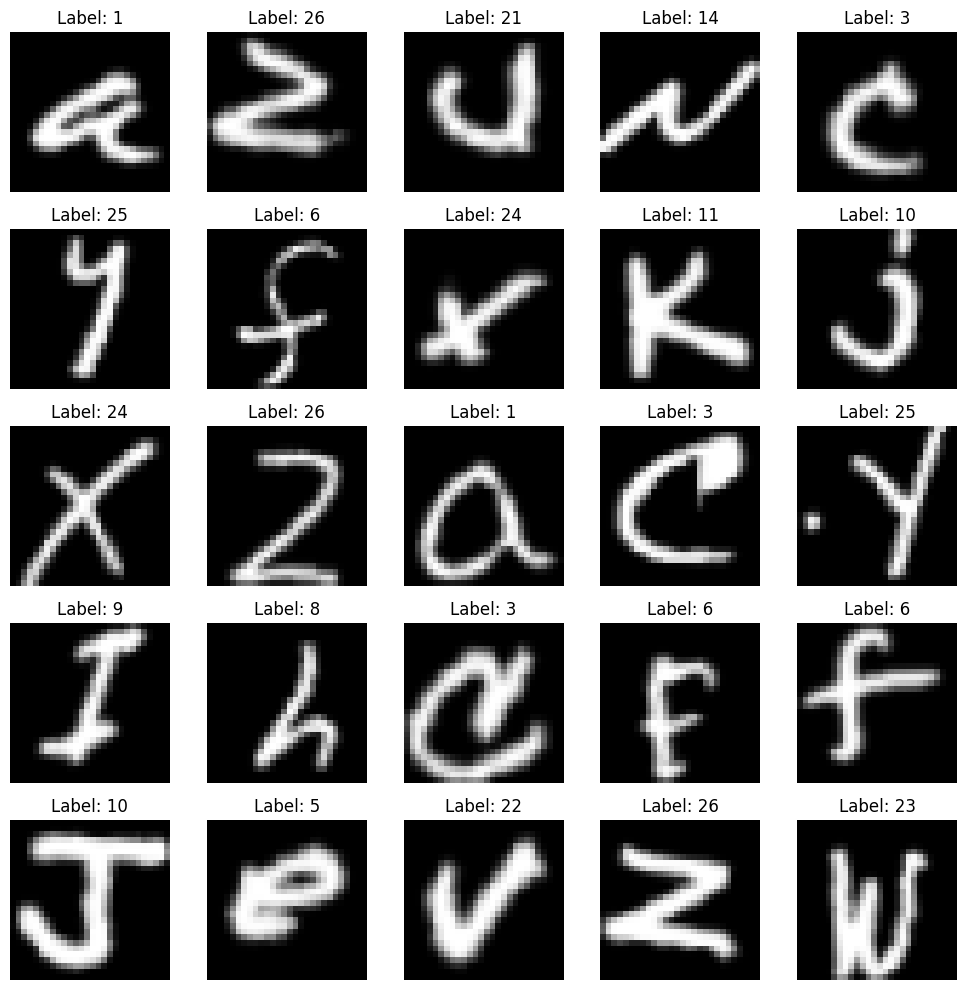

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import exposure



# Define the data augmentation with contrast adjustment
datagen = ImageDataGenerator(
    rotation_range=10,        # Small rotations (e.g., -10 to +10 degrees)
    width_shift_range=0.1,    # Horizontal shifts (e.g., up to 10% of width)
    height_shift_range=0.05,  # Vertical shifts (e.g., up to 10% of height)
    shear_range=0.2,          # Shearing transformations (e.g., up to 20%)
    zoom_range=-0.1,
    fill_mode='nearest'      # Fill mode for edge cases
)

transposed_images = transposed_images.reshape(-1, 28, 28, 1)

# Custom generator to yield augmented images and their labels
def custom_generator(images, labels, batch_size):
    generator = datagen.flow(images, labels, batch_size=batch_size)
    while True:
        augmented_images, augmented_labels = generator.next()
        yield augmented_images, augmented_labels

# Example usage
batch_size = len(transposed_images) // 2
augmented_data_gen = custom_generator(transposed_images, labels, batch_size)

# Fetch a batch of augmented images and labels
augmented_images, augmented_labels = next(augmented_data_gen)

# Plot some augmented images
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(augmented_images[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {augmented_labels[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
print(len(augmented_images))
print(len(augmented_labels))

44399
44399


## Pixel distribution of augmented images

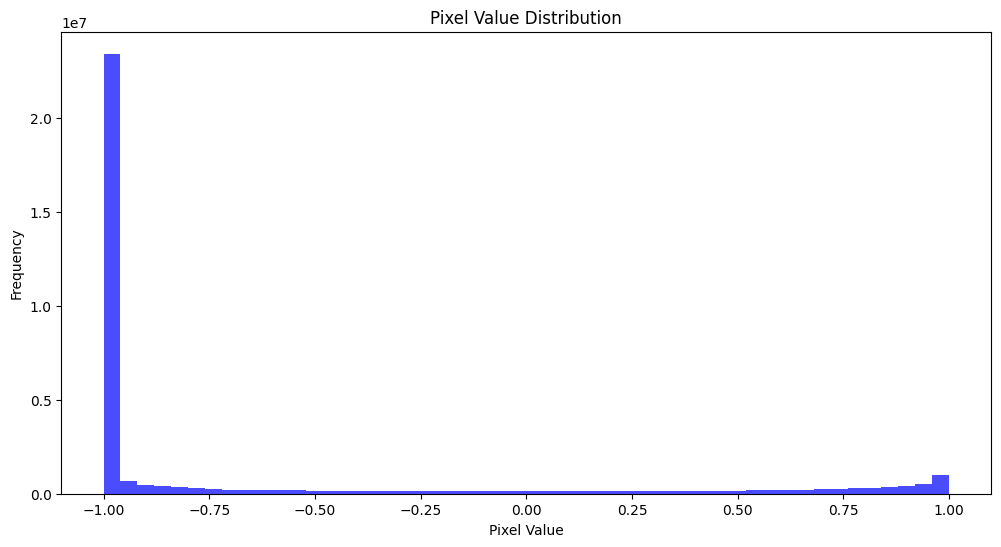

In [ ]:
# Plot pixel value distribution
plt.figure(figsize=(12, 6))
plt.hist(augmented_images.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

By reducing the prevalence of black pixels and minimizing grayscale noise, the images fed into the model become clearer and more focused on the important features (white strokes). This preprocessing improvement allows the model to learn more efficiently from the relevant data.

## Combining into one set

In [ ]:
combined_images = np.concatenate((transposed_images, augmented_images), axis=0)
combined_labels = np.concatenate((labels, augmented_labels), axis=0)

In [ ]:
# Transpose all images
print(combined_images.shape)
print(combined_labels.shape)

(133198, 28, 28, 1)
(133198,)


Our training set is now significantly larger

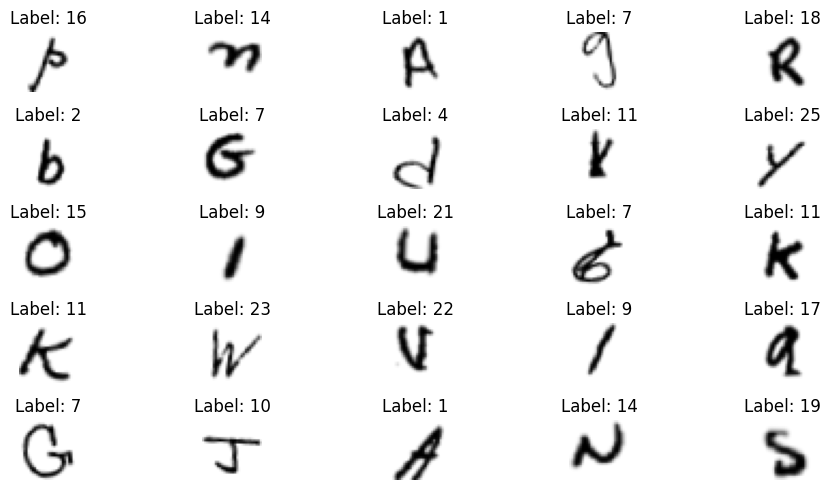

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(combined_images[-(i+1)].reshape(28, 28), cmap='gray_r')
    ax.set_title(f"Label: {combined_labels[-(i+1)]}")
    ax.axis('off')
    ax.axis('off')

plt.tight_layout()
plt.show()


## Training with combined dataset

- To evaluate any potential improvements, I reinitialized the same model with the combined dataset. This approach allows me to compare the performance and quality of the generated images before and after incorporating the additional data. 

- By training the model on a more diverse and comprehensive dataset, I aim to achieve a better generalization, and potentially lower the FID score, thereby producing higher-quality images.



## cGAN

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.feature import canny
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, LeakyReLU, Conv2D, Dropout, Flatten, Input, BatchNormalization, Embedding, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from sklearn.model_selection import train_test_split
import tensorflow as tf
from scipy.linalg import sqrtm
from skimage.transform import resize



# define standalone discriminator
def define_discriminator(input_shape=(28,28,1),n_classes=26):
  # label input
  in_labels = Input(shape=(1,))
  # Embedding for categorical input
  em = Embedding(n_classes,50)(in_labels)
  # scale up the image dimension with linear activations
  d1 = Dense(input_shape[0] * input_shape[1])(em)
  # reshape to additional channel
  d1 = Reshape((input_shape[0],input_shape[1],1))(d1)
  # image input
  image_input = Input(shape=input_shape)
  #  concate label as channel
  merge = Concatenate()([image_input,d1])
  # downsample
  fe = Conv2D(64,(5,5),strides=(2,2),padding='same')(merge)
  fe = LeakyReLU(0.2)(fe)
  fe = Dropout(0.2)(fe)
  fe = Conv2D(64,(5,5),strides=(2,2),padding='same')(fe)
  fe = LeakyReLU(0.2)(fe)
  fe = Dropout(0.2)(fe)
  # downsample
  fe = Conv2D(256,(5,5),strides=(2,2),padding='same')(fe)
  fe = LeakyReLU(0.2)(fe)
  fe = Dropout(0.2)(fe)
  #flatten feature maps
  fe = Flatten()(fe)
  fe = Dropout(0.4)(fe)
  #ouput
  out_layer = Dense(1,activation='sigmoid')(fe)
  #define model
  model = Model([image_input,in_labels],out_layer)
  #compile model
  opt = Adam(lr=0.0002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt,metrics=  ['accuracy'])
  return model

def define_generator(latent_dim, n_classes=26):
    # Label input
    label_input = Input(shape=(1,))
    em = Embedding(n_classes, 50)(label_input)
    nodes = 7 * 7
    em = Dense(nodes)(em)
    em = Reshape((7, 7, 1))(em)
    
    # Latent input
    image_input = Input(shape=(latent_dim,))
    nodes = 128 * 7 * 7
    d1 = Dense(nodes)(image_input)
    d1 = LeakyReLU(0.2)(d1)
    d1 = BatchNormalization()(d1)
    d1 = Reshape((7, 7, 128))(d1)
    
    # Concatenate label as channel
    merge = Concatenate()([d1, em])
    
    # Upsample
    gen = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same')(merge)
    gen = LeakyReLU(0.2)(gen)
    gen = BatchNormalization()(gen)
    
    gen = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same')(gen)
    gen = LeakyReLU(0.2)(gen)
    gen = BatchNormalization()(gen)

    
    # Output
    out_layer = Conv2D(1, (7, 7), activation='tanh', padding='same')(gen)
    model = Model([image_input, label_input], out_layer)
    return model

# defining the combined generator and discriminator model for updating the generator
def define_gan(g_model,d_model):
    d_model.trainable = False
    gen_noise, gen_label = g_model.input
    gen_output = g_model.output
    gan_output = d_model([gen_output,gen_label])
    model = Model([gen_noise,gen_label],gan_output)
    opt = Adam(lr=0.0002,beta_1=0.5)
    model.compile(loss='binary_crossentropy',optimizer=opt)
    return model

# load real samples
def load_real_samples():
    X_train=combined_images
    y_train=combined_labels
    X = np.expand_dims(X_train,axis=-1)
    X = X.astype('float32')
    return [X, y_train]

# Select real samples
def generate_real_samples(dataset, n_samples):
    images, labels = dataset
    ix = np.random.randint(0, images.shape[0], n_samples)
    X, Labels = images[ix], labels[ix]
    y = np.ones((n_samples, 1))
    return [X, Labels], y

# Generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=26):
    x_input = np.random.randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    labels = np.random.randint(1, n_classes + 1, n_samples)  # Ensure labels are 1 to 26
    return [z_input, labels]

# Use generator to generate n fake samples, with class labels
def generate_fake_samples(latent_dim, n_samples, generator):
    z_input, labels = generate_latent_points(latent_dim, n_samples)
    images = generator.predict([z_input, labels])
    y = np.zeros((n_samples, 1))
    return [np.array(images), labels], y

# Save generated images by class
def save_generated_images_by_class(epoch, generator, latent_dim, n_classes=26):
    plt.figure(figsize=(10, 10))
    for class_label in range(n_classes):
        z_input = np.random.randn(1, latent_dim)
        labels = np.array([class_label + 1])  # Ensure labels are 1 to 26
        generated_image = generator.predict([z_input, labels])
        generated_image = (generated_image + 1) / 2.0
        plt.subplot(5, 6, class_label + 1)
        plt.axis('off')
        plt.imshow(generated_image[0, :, :, 0], cmap='gray_r')
        plt.title(chr(65 + class_label))
    filename = f'aug_generated_classes_e{epoch + 1}.png'
    plt.savefig(filename)
    plt.close()

d_loss_real_list, d_loss_fake_list, g_loss_list = [], [], []
d_acc_real_list, d_acc_fake_list = [], []

def train_gan(gen_model,disc_model,gan_model,latent_dim,dataset,n_epochs=50,n_batches=256):
    batches_per_epoch = int(dataset[0].shape[0]/n_batches)
    half_batch = int(n_batches/2)
    for i in range(n_epochs):
        print('Epoch', i + 1)
        
       
        
        for j in range(batches_per_epoch):
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            [X_fake, labels_fake], y_fake = generate_fake_samples(latent_dim, half_batch, gen_model)
            d_loss_real, d_acc_real = disc_model.train_on_batch([X_real, labels_real], y_real)
            d_loss_fake, d_acc_fake = disc_model.train_on_batch([X_fake, labels_fake], y_fake)
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batches)
            y_gan = np.ones((n_batches, 1))
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            d_loss_real_list.append(d_loss_real)
            d_loss_fake_list.append(d_loss_fake)
            d_acc_real_list.append(d_acc_real)
            d_acc_fake_list.append(d_acc_fake)
            g_loss_list.append(g_loss)
        
        d_loss_real_avg = np.mean(d_loss_real_list)
        d_loss_fake_avg = np.mean(d_loss_fake_list)
        d_acc_real_avg = np.mean(d_acc_real_list)
        d_acc_fake_avg = np.mean(d_acc_fake_list)
        g_loss_avg = np.mean(g_loss_list)
        
        print(f'> Discriminator real loss: {d_loss_real_avg:.3f}, acc: {d_acc_real_avg:.3f}')
        print(f'> Discriminator fake loss: {d_loss_fake_avg:.3f}, acc: {d_acc_fake_avg:.3f}')
        print(f'> Generator loss: {g_loss_avg:.3f}')
        
        if (i + 1) % 10 == 0 or i == 0:
            gen_model.save(f'aug_c_gan_{i+1}.h5')
            save_generated_images_by_class(i, gen_model, latent_dim)

# Load real samples
dataset = load_real_samples()

# Size of the latent space
latent_dim = 100

# Create the discriminator
d_model = define_discriminator()
d_model.summary()

# Create the generator
g_model = define_generator(latent_dim)
g_model.summary()

# Create the GAN
gan_model = define_gan(g_model, d_model)

# Train the GAN
train_gan(g_model, d_model, gan_model, latent_dim, dataset)


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 50)        1300        ['input_10[0][0]']               
                                                                                                  
 dense_8 (Dense)                (None, 1, 784)       39984       ['embedding_5[0][0]']            
                                                                                                  
 input_11 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                            

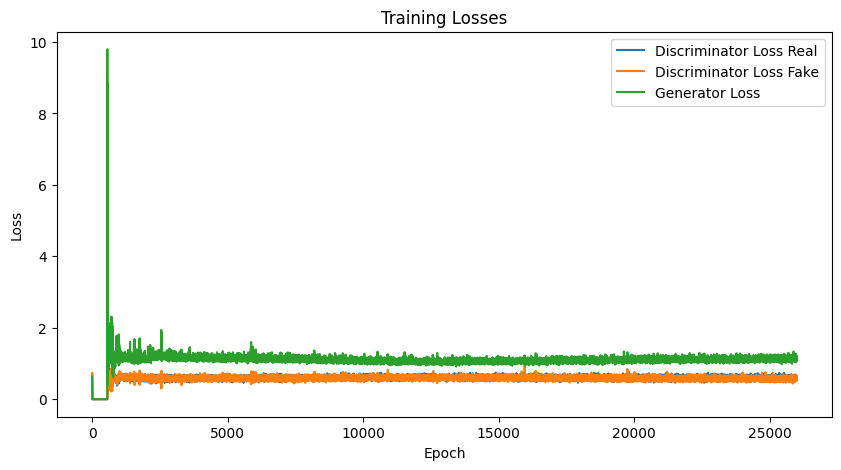

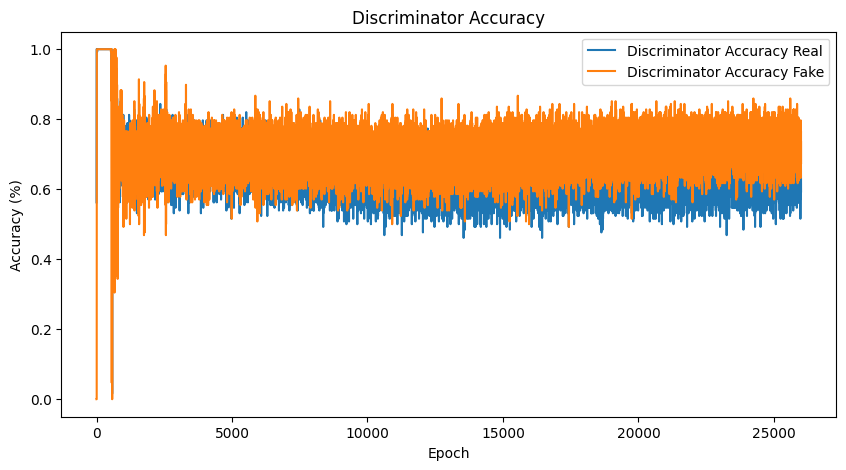

In [ ]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(d_loss_real_list, label="Discriminator Loss Real")
plt.plot(d_loss_fake_list, label="Discriminator Loss Fake")
plt.plot(g_loss_list, label="Generator Loss")
plt.title("Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("CGAN/aug_cgan_losses.png")
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(d_acc_real_list, label="Discriminator Accuracy Real")
plt.plot(d_acc_fake_list, label="Discriminator Accuracy Fake")
plt.title("Discriminator Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.savefig("CGAN/aug_cgan_accuracies.png")
plt.show()

## Evaluation

Results of CGAN with augmented dataset:​

The real and fake discriminator accuracy showed fluctuations initially, however they stabilize and converge at around 60% mark.​

The generator and discriminator losses have converged, with the difference between them no longer being significant. This indicates that overfitting is no longer an issue, an improvement compared to the baseline.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def save_generated_images_by_class(generator, latent_dim, n_classes=26, n_images=10):
    # Define the splitting point
    midpoint = n_classes // 2

    # Generate and save images for the first half of the classes (A to M)
    plt.figure(figsize=(10, 10))  
    image_index = 1

    for class_label in range(midpoint):
        for i in range(n_images):
            z_input = np.random.randn(1, latent_dim)
            labels = np.array([class_label + 1])  # Ensure labels are 1 to 26
            generated_image = generator.predict([z_input, labels])
            generated_image = (generated_image + 1) / 2.0  # Rescale to [0, 1]

            # Plot the generated image
            plt.subplot(midpoint, n_images, image_index)
            plt.axis('off')
            plt.imshow(generated_image[0, :, :, 0], cmap='gray_r')
            
            if i == 0:
                plt.title(chr(65 + class_label), fontsize=12)  # Label the first image of each row with the class letter
            
            image_index += 1

    plt.tight_layout()
    filename = f'augmentedgenerated_classes_first_half.png'
    plt.savefig(filename, dpi=300)
    plt.close()

    # Generate and save images for the second half of the classes (N to Z)
    plt.figure(figsize=(10, 10)) 
    image_index = 1

    for class_label in range(midpoint, n_classes):
        for i in range(n_images):
            z_input = np.random.randn(1, latent_dim)
            labels = np.array([class_label + 1])
            generated_image = generator.predict([z_input, labels])
            generated_image = (generated_image + 1) / 2.0  # Rescale to [0, 1]

            # Plot the generated image
            plt.subplot(midpoint, n_images, image_index)
            plt.axis('off')
            plt.imshow(generated_image[0, :, :, 0], cmap='gray_r')
            
            if i == 0:
                plt.title(chr(65 + class_label), fontsize=12)  # Label the first image of each row with the class letter
            
            image_index += 1

    plt.tight_layout()
    filename = f'augmentedgenerated_classes_second_half.png'
    plt.savefig(filename, dpi=300)
    plt.close()

save_generated_images_by_class(generator=g_model, latent_dim=100)


1/1 [==============================] - 0s 26ms/step


## DCGAN

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.feature import canny
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, LeakyReLU, Conv2D, Dropout, Flatten, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import tensorflow as tf
from scipy.linalg import sqrtm
from skimage.transform import resize
from scipy.stats import entropy



class DCGAN:
    def __init__(self, rows=28, cols=28, channels=1):
        # Input shape
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100  # Latent space dimension (input noise vector size)
        
        # Optimizer
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        
        # Build the generator
        self.generator = self.build_generator()
        
        # The generator takes noise as input and generates images
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        
        # For the combined model, we will only train the generator
        self.discriminator.trainable = False
        
        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)
        
        # The combined model (stacked generator and discriminator)
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

        # Initialize lists to store losses and accuracy
        self.d_losses = []
        self.g_losses = []
        self.d_accuracies = []
        self.g_accuracies = []
        
        
        self.v3_fid_scores = []
        self.v3_inception_scores = []

        self.lenet_fid_scores = []
        self.lenet_inception_scores = []

        self.lenet_lowest_fid = float('inf')
        self.lenet_best_inception_score = 0

        self.v3_lowest_fid = float('inf')
        self.v3_best_inception_score = 0

        # Load LeNet-5 model
        self.lenet_model = load_model('lenet_model.h5')

        # Feature extraction model
        self.feature_extractor = Model(inputs=self.lenet_model.input,
                                       outputs=self.lenet_model.get_layer(index=-2).output)

        # Load InceptionV3 model
        self.inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(75, 75, 3))


    def build_generator(self):
        model = Sequential(name='Generator')
        
        model.add(Dense(64 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 64)))
        model.add(BatchNormalization(momentum=0.8))
        
        # First Conv2DTranspose layer
        model.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))


        # Second Conv2DTranspose layer
        model.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        # Final Conv2D layer to get the desired output shape
        model.add(Conv2D(self.channels, kernel_size=3, padding='same', activation='tanh'))
        
        model.summary()
        
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        
        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential(name='Discriminator')
        model.add(Conv2D(256, kernel_size=5, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=7, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=5, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=self.img_shape)
        validity = model(img)
        
        return Model(img, validity)


    def preprocess_lenet(self, images):
        images = np.array([resize(image, (28, 28, 1)) for image in images])
        return images
        
    def calculate_lenet_fid(self, real_images, generated_images):
        real_images = self.preprocess_lenet(real_images)
        generated_images = self.preprocess_lenet(generated_images)

        real_activations = self.feature_extractor.predict(real_images)
        generated_activations = self.feature_extractor.predict(generated_images)

        # Check for NaNs in activations
        assert not np.any(np.isnan(real_activations)), "NaNs found in real activations"
        assert not np.any(np.isnan(generated_activations)), "NaNs found in generated activations"

        mu_real = np.mean(real_activations, axis=0)
        sigma_real = np.cov(real_activations, rowvar=False)
        mu_gen = np.mean(generated_activations, axis=0)
        sigma_gen = np.cov(generated_activations, rowvar=False)

        # Add small value to diagonal of covariance matrices
        epsilon = 1e-6
        sigma_real += np.eye(sigma_real.shape[0]) * epsilon
        sigma_gen += np.eye(sigma_gen.shape[0]) * epsilon

        ssdiff = np.sum((mu_real - mu_gen) ** 2.0)
        covmean = sqrtm(sigma_real @ sigma_gen)

        if np.iscomplexobj(covmean):
            covmean = covmean.real

        fid = ssdiff + np.trace(sigma_real + sigma_gen - 2.0 * covmean)
        return fid

    def calculate_lenet_inception_score(self, generated_images, num_splits=10):
        generated_images = self.preprocess_lenet(generated_images)

        # Predict class probabilities using the LeNet-5 model
        preds = self.lenet_model.predict(generated_images)

        # Calculate the Inception Score
        split_scores = []
        for k in range(num_splits):
            part = preds[k * len(preds) // num_splits: (k + 1) * len(preds) // num_splits]
            py = np.mean(part, axis=0)
            scores = []
            for i in range(part.shape[0]):
                pyx = part[i]
                scores.append(entropy(pyx, py))
            split_scores.append(np.exp(np.mean(scores)))
        return np.mean(split_scores), np.std(split_scores)

    def preprocess_v3(self, images):
        images = np.array([resize(image, (75, 75, 3)) for image in images])
        images = preprocess_input(images)
        return images

    def calculate_v3_fid(self, real_images, generated_images):
        real_images = self.preprocess_v3(real_images)
        generated_images = self.preprocess_v3(generated_images)

        real_activations = self.inception_model.predict(real_images)
        generated_activations = self.inception_model.predict(generated_images)

        # Check for NaNs in activations
        assert not np.any(np.isnan(real_activations)), "NaNs found in real activations"
        assert not np.any(np.isnan(generated_activations)), "NaNs found in generated activations"

        mu_real = np.mean(real_activations, axis=0)
        sigma_real = np.cov(real_activations, rowvar=False)
        mu_gen = np.mean(generated_activations, axis=0)
        sigma_gen = np.cov(generated_activations, rowvar=False)

        # Add small value to diagonal of covariance matrices
        epsilon = 1e-6
        sigma_real += np.eye(sigma_real.shape[0]) * epsilon
        sigma_gen += np.eye(sigma_gen.shape[0]) * epsilon

        ssdiff = np.sum((mu_real - mu_gen) ** 2.0)
        covmean = sqrtm(sigma_real @ sigma_gen)

        if np.iscomplexobj(covmean):
            covmean = covmean.real

        fid = ssdiff + np.trace(sigma_real + sigma_gen - 2.0 * covmean)
        return fid

    def calculate_v3_inception_score(self, generated_images, num_splits=10):
        generated_images = self.preprocess_v3(generated_images)

        # Predict class probabilities using the InceptionV3 model
        preds = self.inception_model.predict(generated_images)

        # Calculate the Inception Score
        split_scores = []
        for k in range(num_splits):
            part = preds[k * len(preds) // num_splits: (k + 1) * len(preds) // num_splits]
            py = np.mean(part, axis=0)
            scores = []
            for i in range(part.shape[0]):
                pyx = part[i]
                scores.append(entropy(pyx, py))
            split_scores.append(np.exp(np.mean(scores)))
        return np.mean(split_scores), np.std(split_scores)

    

    def train(self, X_train, epochs, batch_size=128, save_interval=50):
        
        # Adversarial ground truths
        valid = np.random.uniform(0.7, 1.2, (batch_size, 1))  # Smoothed real labels
        fake = np.zeros((batch_size, 1)) 
        
        for epoch in range(epochs):
            # Train Discriminator
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # Train Generator
            g_loss = self.combined.train_on_batch(noise, valid)

            
            self.d_losses.append(d_loss[0])
            self.g_losses.append(g_loss)
            self.d_accuracies.append(100 * d_loss[1])


            # Plot the progress
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]:.2f}%] [G loss: {g_loss}]")
            
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

                # Calculate FID score
                fid_score = self.calculate_fid(X_train, gen_imgs)
                self.fid_scores.append(fid_score)
                print(f"FID score: {fid_score}")
                if fid_score < self.lowest_fid:
                    self.lowest_fid = fid_score
                    self.generator.save_weights('aug_best_generator_weights.h5')
                    self.discriminator.save_weights('aug_best_discriminator_weights.h5')
                    print(f"New lowest FID score: {fid_score}. Model weights saved.")

                # Calculate Inception Score
                inception_score, inception_std = self.calculate_inception_score(gen_imgs)
                self.inception_scores.append((inception_score, inception_std))
                print(f"Inception Score: {inception_score} ± {inception_std}")
                if inception_score > self.best_inception_score:
                    self.best_inception_score = inception_score
                    self.generator.save_weights('aug_inception_generator_weights.h5')
                    print(f"New best Inception Score: {inception_score}. Model weights saved.")



    def add_instance_noise(self, images, noise_level=0.1):
        noise = np.random.normal(0, noise_level, images.shape)
        return images + noise


    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        fig, axs = plt.subplots(r, c, figsize=(10, 10))
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1

        os.makedirs('augmented_model', exist_ok=True)
        fig.savefig(f"augmented_model/dcgan_mnist_{epoch}.png")
        plt.close()
        

        
    def plot_losses(self):
        # Plot losses
        plt.figure(figsize=(10, 5))
        plt.plot(self.d_losses, label="Discriminator Loss")
        plt.plot(self.g_losses, label="Generator Loss")
        plt.title("Training Losses")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"augmented_model/dcgan_losses.png")
        plt.show()

        # Plot accuracy
        plt.figure(figsize=(10, 5))
        plt.plot(self.d_accuracies, label="Discriminator Accuracy")
        plt.title("Discriminator Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.legend()
        plt.savefig(f"augmented_model/dcgan_accuracy.png")
        plt.show()

        # Calculate the correct x-axis values for FID scores and Inception scores
        intervals = list(range(0, len(self.lenet_fid_scores) * 50, 50))

        # Plot combined FID scores
        plt.figure(figsize=(10, 5))
        plt.plot(intervals, self.lenet_fid_scores, label="Lenet FID Score")
        plt.plot(intervals, self.v3_fid_scores, label="V3 FID Score")
        plt.title("FID Scores")
        plt.xlabel("Epoch")
        plt.ylabel("FID Score")
        plt.xticks(intervals)  # Set x-axis ticks to match intervals
        plt.legend()
        plt.savefig(f"augmented_model/combined_fid_scores.png")
        plt.show()

        # Prepare Lenet and V3 Inception scores
        lenet_inception_scores = [score for score, std in self.lenet_inception_scores]
        lenet_inception_stds = [std for score, std in self.lenet_inception_scores]
        v3_inception_scores = [score for score, std in self.v3_inception_scores]
        v3_inception_stds = [std for score, std in self.v3_inception_scores]

        # Plot combined Inception Scores
        plt.figure(figsize=(10, 5))
        plt.errorbar(intervals, lenet_inception_scores, yerr=lenet_inception_stds, fmt='-o', label="Lenet Inception Score")
        plt.errorbar(intervals, v3_inception_scores, yerr=v3_inception_stds, fmt='-o', label="V3 Inception Score")
        plt.title("Inception Scores")
        plt.xlabel("Epoch")
        plt.ylabel("Inception Score")
        plt.xticks(intervals)  # Set x-axis ticks to match intervals
        plt.legend()
        plt.savefig(f"augmented_model/combined_inception_scores.png")
        plt.show()
        plt.close()

        # Print the lowest FID score and best Inception Score
        print(f"Lowest Lenet FID score: {self.lenet_lowest_fid}")
        print(f"Best Lenet Inception Score: {self.lenet_best_inception_score}")
        print(f"Lowest V3 FID score: {self.v3_lowest_fid}")
        print(f"Best V3 Inception Score: {self.v3_best_inception_score}")
        
        self.generator.save_weights('final_aug_best_generator_weights.h5')
        self.discriminator.save_weights('final_aug_best_discriminator_weights.h5')

# Instantiate and train the DCGAN
dcgan = DCGAN()
dcgan.train(combined_images, epochs=15001, batch_size=64, save_interval=50)
dcgan.plot_losses()


Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_693 (Conv2D)         (None, 14, 14, 256)       6656      
                                                                 
 leaky_re_lu_46 (LeakyReLU)  (None, 14, 14, 256)       0         
                                                                 
 dropout_27 (Dropout)        (None, 14, 14, 256)       0         
                                                                 
 conv2d_694 (Conv2D)         (None, 7, 7, 128)         819328    
                                                                 
 leaky_re_lu_47 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_28 (Dropout)        (None, 7, 7, 128)         0         
                                                                 
 conv2d_695 (Conv2D)         (None, 4, 4, 64)        

NameError: name 'combined_images' is not defined

## Conclusion

CGAN works the best with the given EMNIST dataset to generate handwritten letters​

Augmented data improves the model with the generation of the images​

Lenet-5 is most effective in measuring the inception score and FID​

